In [108]:
#################### Params ###############

NOVA_HOME = '/home/labs/hornsteinlab/Collaboration/NOVA_GAL/NOVA'
preprocessing_path = "/home/labs/hornsteinlab/Collaboration/FUNOVA/outputs/preprocessing/brenner"
csv_name = 'raw_metrics240225_exp4.csv'
site_csv_name = 'raw_metrics110225_exp4.csv'
mappings_filepath = "/home/labs/hornsteinlab/Collaboration/NOVA_GAL/NOVA/manuscript/markers_focus_boundries/markers_focus_boundries_funova_Exp4_tiles.csv"
imgs_path = '/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/'

metric_name = 'Target_Sharpness_Brenner'
img_shape = 1024
tile_shape = [100, 100]
percentiles_resolution = 0.0001
percentile_ranges_for_reports = [0, 0.1, 0.2, 0.3, 0.5, 0.7, 1, 2, 5, 10, 15, 20, 30, 40, 60, 75, 80, 85, 90, 95, 98, 99, 99.5, 99.7, 99.8,99.9,100]

In [2]:
import os
import sys
import concurrent.futures
import numpy as np
import pandas as pd
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from datetime import datetime
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.gridspec import GridSpec

os.environ['NOVA_HOME'] = NOVA_HOME
sys.path.insert(1, os.getenv("NOVA_HOME"))
print(f"NOVA_HOME: {os.getenv('NOVA_HOME')}")

from src.preprocessing.preprocessing_utils import get_image_focus_quality, crop_image_to_tiles, rescale_intensity, fit_image_shape

%reload_ext autoreload
%autoreload 2
%aimport

%matplotlib inline

NOVA_HOME: /home/labs/hornsteinlab/Collaboration/NOVA_GAL/NOVA
Modules to reload:
all-except-skipped

Modules to skip:



# Utils

In [185]:
def get_metrics(tile, as_string=False):
    sharpness_brenner = get_image_focus_quality(tile)    
    if as_string:
        return f"Brenner: {round(sharpness_brenner, 3)}"
    return sharpness_brenner

def show_images(df, max_samples = 10, show_tile = False):
    for ind, path in enumerate(df.Path.values):
        print(ind)
        if max_samples is not None and ind >= max_samples:
            print(f"Stopping at {ind}. There are {len(df.Path.values)} images in total")
            break
        
        # Target
        target_path = os.path.join(imgs_path, path)
        show_processed_tif(target_path)
        tile_index = df_marker_filtered['Tile'].iloc[ind]
        print(tile_index, target_path)
        x,y = get_tile_location(tile_index, [img_shape, img_shape], tile_shape)
        plt.gca().add_patch(plt.Rectangle((x, y), tile_shape[0], tile_shape[1], edgecolor='red', linewidth=2, fill=False))
        plt.show()
        
        if show_tile:
            img = process_tif(target_path)
            tiles = crop_image_to_tiles(img, [100, 100])
            img = tiles[tile_index]
            print("SNR:", compute_snr(img))
            print("Entropy:", compute_entropy(img))
            plt.imshow(img, cmap='gray')
            plt.axis('off')
            labels = show_label(path)
            perc_brenner = abs(percentiles[[per for per in percentiles.keys() if '%' in per]] - get_image_focus_quality(img)).idxmin()
            plt.title(f"{tile_index}: {labels[1]}, {labels[3]}, {get_metrics(img, True)}, {perc_brenner}", color='purple', fontsize=10)
            plt.show()
        # His DAPI
        # path_l = target_path.split("/")
        # path_l[-2] = 'DAPI'
        
        # file_name = path_l[-1].split("_")
        # dapi_file_name = "_".join([file_name[0], 'w1confDAPI', file_name[-1]])
        # dapi_file_name = "/".join([*path_l[:-1], dapi_file_name])
        # print(dapi_file_name)

        # show_processed_tif(dapi_file_name)
        print('--------------------------------')
        
def init_mappings(markers=[], filepath=None):
    if filepath is not None:     
        if os.path.exists(filepath):
            mappings = pd.read_csv(filepath, index_col=0)
            return mappings
        
    mappings = pd.DataFrame(columns=['Lower_bound', 'Upper_bound'], index=markers)

    return mappings
        
def save_to_mapping(filepath, mappings, marker, value, is_upper_bound):
    col = 'Upper_bound' if is_upper_bound else 'Lower_bound' 
    mappings.loc[marker, col] = value
    
    mappings.to_csv(filepath)
    print(f"File saved to {filepath}")

def show_label(path):
    path_l = path.split("/")
    return path_l[-7:]

def process_tif(path):
    """
    Read and process the image.

    Parameters:
        path (str): Path to the image file.

    Returns:
        ndarray: Processed image.
    """
    # read the image stack
    img = cv2.imread(path, cv2.IMREAD_ANYDEPTH)
    img = fit_image_shape(img, (img_shape, img_shape))
    # rescale pixel intensities
    img = rescale_intensity(img)
    return img
    
def show_processed_tif(path):
    img = process_tif(path)
    print(get_metrics(img, True))
    # show the image with grid 
    fig, ax = plt.subplots(figsize=(7,7))
    plt.imshow(img, cmap='gray')
    put_tiles_grid(image=img, ax=ax)
    plt.axis('off')
    plt.title(show_label(path), color='purple')
    print(f"Img shape: {img.shape}")

def put_tiles_grid(image, ax):
    # assumes 1000x1000 image
    import matplotlib.patches as patches

    # Add dashed grid lines for 64 blocks
    num_blocks = 10
    block_size = 100

    for i in range(1, num_blocks):
        # Draw horizontal dashed lines
        ax.plot([0, 1000], [i * block_size, i * block_size], linestyle='--', lw=1, alpha=0.5, color='pink')

        # Draw vertical dashed lines
        ax.plot([i * block_size, i * block_size], [0, 1000], linestyle='--', lw=1, alpha=0.5, color='pink')

    # Remove x and y axis labels
    ax.set_xticks([])
    ax.set_yticks([])

    # Add a title
    plt.title('Image with Dashed Grid of 64 Blocks')

def update_all_mappings(mappings, thresholds, df):
    # Iterate over the rows and fill the thresholds
    for marker in mappings.index:
        if marker in thresholds and thresholds[marker] is not None:
            df_marker = df.loc[df['Marker'] == marker]
            percentiles = df_marker[metric_name].describe(percentiles=percentiles_to_describe)
            mappings.loc[marker, "Lower_bound"] = round(percentiles[f'{thresholds[marker][0]}%'], 2)
            mappings.loc[marker, "Upper_bound"] = round(percentiles[f'{thresholds[marker][1]}%'], 2)
    return mappings

def create_histogram_report_by_batch(df: pd.DataFrame, all_markers: list) -> None:
    """
    Generate a PDF report with histograms for each marker.

    Parameters:
        df (pd.DataFrame): DataFrame containing the images data.
        all_markers (list): List of unique markers.

    Returns:
        None
    """    
    with PdfPages('Marker_histogram_by_batch.pdf') as pdf:
        for marker in all_markers:
            print(marker)
            df_marker = df.loc[df['Marker'] == marker]
            percentiles = df_marker[metric_name].describe(percentiles=percentiles_to_describe)
            create_histogram(
                df_marker, percentiles, 
                low_perc=thresholds[marker][0], 
                high_perc=thresholds[marker][1], 
                overlay_group=['Batch'], 
                x_min=0.1, x_max=99.9
            )
            plt.title(marker)
            pdf.savefig()
            plt.close()
            
def create_histogram(
    df_marker: pd.DataFrame, 
    percentiles: pd.Series, 
    low_perc: float = 0.5, 
    high_perc: float = 99.9, 
    x_min: float = None, 
    x_max: float = None, 
    overlay_group: list = None,
    plot_base: bool = True,
    actual_x_limits: tuple = None
) -> None:
    """
    Create a histogram of the Brenner values of a certain marker.

    Parameters:
        df_marker (pd.DataFrame): Marker's data.
        percentiles (pd.Series): Percentile values for annotations.
        low_perc (float): Low percentile threshold for annotations.
        high_perc (float): High percentile threshold for annotations.
        x_min (float, optional): Minimum x-axis value for the histogram.
        x_max (float, optional): Maximum x-axis value for the histogram.
        overlay_group (list, optional): Columns to group and overlay histograms.
        plot_base (bool): Whether to plot the base histogram.
        actual_x_limits (tuple, optional): Tuple specifying actual x_min and x_max values.

    Returns:
        None
    """
    assert low_perc < high_perc, "'low_perc' must be less than 'high_perc'"
    
    # Determine histogram range
    if actual_x_limits:
        hist_range = actual_x_limits  # Use passed x_min and x_max
    else:
        hist_range = (percentiles[f'{x_min}%'], percentiles[f'{x_max}%']) if x_min is not None and x_max is not None else None
    
    # Plot base histogram
    if plot_base:
        plt.hist(df_marker[metric_name].values, bins=100, range=hist_range, color=plt.cm.tab10(range(1))[0], 
                 alpha=0.3, label='Brenner scores')
    
    # Plot overlays
    if overlay_group is not None:
        grouped_data = df_marker.groupby(overlay_group)
        unique_groups = grouped_data.groups.keys()
        colors = plt.cm.tab10(range(len(unique_groups)))

        for color, group in zip(colors, unique_groups):
            group_data = grouped_data.get_group(group)
            group_label = ' - '.join(map(str, group)) if isinstance(group, tuple) else group
            plt.hist(group_data[metric_name].values, bins=100, range=hist_range, alpha=0.4, label=group_label, color=color)

    # Add percentile markers
    plt.scatter(percentiles['50%'], 0.5, color='yellow', s=12, label='50th percentile')
    plt.scatter(percentiles[f'{high_perc}%'], 0.5, color='orange', s=12, label=f'{high_perc}th percentile')
    plt.scatter(percentiles[f'{low_perc}%'], 0.5, color='red', s=12, label=f'{low_perc}th percentile')

    # Remove duplicate legend entries
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())

def generate_marker_reports(
    df: pd.DataFrame, 
    all_markers: list, 
    output_folder: str, 
    percentiles_to_describe: list, 
    percentile_ranges: list, 
    max_samples: int
) -> None:
    """
    Generate a detailed report for each marker, including histograms and filtered images.

    Parameters:
        df (pd.DataFrame): DataFrame containing the data.
        all_markers (list): List of unique markers.
        output_folder (str): Path to save the output PDFs.
        percentiles_to_describe (list): List of percentiles to describe the metric.
        percentile_ranges (list): List of percentile ranges for filtering.
        max_samples (int): Maximum number of images to display per range.

    Returns:
        None
    """
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for marker in all_markers:
        print(marker)
        df_marker = df.loc[df['Marker'] == marker]
        percentiles = df_marker[metric_name].describe(percentiles=percentiles_to_describe)

        # Define the actual x-axis limits for consistent base and overlay histograms
        actual_x_limits = (percentiles['0%'], percentiles['97%'])

        pdf_path = os.path.join(output_folder, f'output_report_{marker}.pdf')
        with PdfPages(pdf_path) as pdf:
            # Generate histograms with overlays for different groups
            groups = ['Condition', 'Batch', 'Rep', 'CellLine']
            for group in groups:
                create_histogram(
                    df_marker,
                    percentiles,
                    low_perc=0,
                    high_perc=97,
                    actual_x_limits=actual_x_limits,
                    overlay_group=[group]
                )
                plt.title(f"Histogram with Overlay by {group}")
                pdf.savefig()  # Save current figure to the PDF
                plt.close()

            # Combined base histogram and overlay for each cell line
            for CL in np.unique(df_marker['CellLine']):
                create_histogram(
                    df_marker,
                    percentiles,
                    low_perc=0,
                    high_perc=97,
                    actual_x_limits=actual_x_limits,
                )
                
                # Filter and overlay the specific cell line
                df_tmp = df_marker.loc[df_marker['CellLine'] == CL]
                percentiles_tmp = df_tmp[metric_name].describe(percentiles=percentiles_to_describe)
                create_histogram(
                    df_tmp,
                    percentiles,
                    low_perc=0,
                    high_perc=97,
                    actual_x_limits=actual_x_limits,
                    overlay_group=['CellLine', 'Condition'], plot_base = False
                )
                plt.title(f"Histogram for (Cell Line: {CL})")
                # Save the combined plot to the PDF
                pdf.savefig()
                plt.close()

            # Remaining parts of the function (filtered images, percentile ranges, etc.)
            for i in range(len(percentile_ranges) - 1):
                per_min = np.round(percentile_ranges[i], 2)
                per_max = np.round(percentile_ranges[i + 1], 2)
                assert per_min < per_max, "Percentile range minimum must be less than the maximum."
                threshold = percentiles[f'{per_min}%']
                threshold_second = percentiles[f'{per_max}%']

                c = (df_marker[metric_name] >= threshold) & (df_marker[metric_name] <= threshold_second)
                df_marker_filtered = df_marker[c].sample(frac=1, random_state=1)

                text_output = (f'Images between %{per_min} - {per_max}%\n'
                               f"Number of {marker} images in threshold {threshold} "
                               f"({per_min}%) and {threshold_second} ({per_max}%): "
                               f"{len(df_marker_filtered)}\n\n"
                               f"{df_marker_filtered['CellLine'].value_counts().to_string()}\n\n"
                               f"{df_marker_filtered['Condition'].value_counts().to_string()}\n\n")

                fig = plt.figure(figsize=(12, 8))
                gs = GridSpec(3, 1, figure=fig, height_ratios=[1, 2, 0.1])
                text_ax = fig.add_subplot(gs[0, :])
                text_ax.axis('off')
                text_ax.text(0.01, 0.99, text_output, ha='left', va='top', fontsize=12, wrap=True)

                filtered_paths = df_marker_filtered['Path'].values
                num_images = min(max_samples, len(filtered_paths))
                img_gs = gs[1].subgridspec(1, num_images, wspace=0.1)

                for ind, path in enumerate(filtered_paths[:num_images]):
                    target_path = os.path.join(output_folder, path)
                    print(target_path)
                    img = process_tif(target_path)
                    tiles = crop_image_to_tiles(img, [100, 100])
                    img = tiles[df_marker_filtered['Tile'].iloc[ind]]
#                     print(df_marker_filtered['original_Path'].iloc[ind], df_marker_filtered['Tile'].iloc[ind],
#                          df_marker_filtered['Path'].iloc[ind])

                    ax = fig.add_subplot(img_gs[0, ind])
                    ax.imshow(img, cmap='gray')
#                     put_tiles_grid(image=img, ax=ax)
                    ax.axis('off')

                    labels = show_label(path)
                    perc_brenner = abs(percentiles[[per for per in percentiles.keys() if '%' in per]] - get_image_focus_quality(img)).idxmin()
                    ax.set_title(f"{labels[1]}, {labels[3]}, {get_metrics(img, True)}, {perc_brenner}", color='purple', fontsize=10)

                plt.tight_layout()
                pdf.savefig(fig)
                plt.close(fig)
def get_tile_location(tile_index: int, img_shape, tile_shape):
    """
    Compute the top-left corner (x, y) location of a tile in the original image.

    Args:
        tile_index (int): Index of the tile in the flattened tiles array.
        img_shape (Tuple[int, int]): Shape of the original image (width, height).
        tile_shape (Tuple[int, int]): Shape of a tile (tile_width, tile_height).

    Returns:
        Tuple[int, int]: (x, y) coordinates of the tile's top-left corner in the image.
    """
    img_height, img_width = img_shape  
    tile_height, tile_width = tile_shape

    n_cols = img_width // tile_width  # Number of tiles per row
    row = tile_index // n_cols  # Get row index
    col = tile_index % n_cols  # Get column index

    x = col * tile_width  # X position (left)
    y = row * tile_height  # Y position (top)
    
    return (x, y)

# Main

In [6]:
df = pd.read_csv(os.path.join(preprocessing_path, csv_name))
df

Path  \
0       /home/labs/hornsteinlab/Collaboration/FUNOVA/i...   
1       /home/labs/hornsteinlab/Collaboration/FUNOVA/i...   
2       /home/labs/hornsteinlab/Collaboration/FUNOVA/i...   
3       /home/labs/hornsteinlab/Collaboration/FUNOVA/i...   
4       /home/labs/hornsteinlab/Collaboration/FUNOVA/i...   
...                                                   ...   
767995  /home/labs/hornsteinlab/Collaboration/FUNOVA/i...   
767996  /home/labs/hornsteinlab/Collaboration/FUNOVA/i...   
767997  /home/labs/hornsteinlab/Collaboration/FUNOVA/i...   
767998  /home/labs/hornsteinlab/Collaboration/FUNOVA/i...   
767999  /home/labs/hornsteinlab/Collaboration/FUNOVA/i...   

                                               RootFolder     Marker  \
0       /home/labs/hornsteinlab/Collaboration/FUNOVA/i...  Autophagy   
1       /home/labs/hornsteinlab/Collaboration/FUNOVA/i...  Autophagy   
2       /home/labs/hornsteinlab/Collaboration/FUNOVA/i...  Autophagy   
3       /home/labs/hornsteinlab/Collaboration/FUNOVA/i...  Autophagy   
4       /home/labs/hornsteinlab/Collaboration/FUNOVA/i...  Autophagy   
...                                                   ...        ...   
767995  /home/labs/hornsteinlab/Collaboration/FUNOVA/i...       DAPI   
767996  /home/labs/hornsteinlab/Collaboration/FUNOVA/i...       DAPI   
767997  /home/labs/hornsteinlab/Collaboration/FUNOVA/i...       DAPI   
767998  /home/labs/hornsteinlab/Collaboration/FUNOVA/i...       DAPI   
767999  /home/labs/hornsteinlab/Collaboration/FUNOVA/i...       DAPI   

        Condition               CellLine    Batch_Rep   Rep   Batch  \
0       Untreated    C9orf72-HRE-1008566  Batch3/rep1  rep1  Batch3   
1       Untreated    C9orf72-HRE-1008566  Batch3/rep1  rep1  Batch3   
2       Untreated    C9orf72-HRE-1008566  Batch3/rep1  rep1  Batch3   
3       Untreated    C9orf72-HRE-1008566  Batch3/rep1  rep1  Batch3   
4       Untreated    C9orf72-HRE-1008566  Batch3/rep1  rep1  Batch3   
...           ...                    ...          ...   ...     ...   
767995     stress  TDP--43-N390D-1005373  Batch3/rep1  rep1  Batch3   
767996     stress  TDP--43-N390D-1005373  Batch3/rep1  rep1  Batch3   
767997     stress  TDP--43-N390D-1005373  Batch3/rep1  rep1  Batch3   
767998     stress  TDP--43-N390D-1005373  Batch3/rep1  rep1  Batch3   
767999     stress  TDP--43-N390D-1005373  Batch3/rep1  rep1  Batch3   

        Target_Sharpness_Brenner  
0                       0.414612  
1                       0.487805  
2                       0.303374  
3                       0.230117  
4                       0.219192  
...                          ...  
767995                  0.276915  
767996                  0.266193  
767997                  0.288866  
767998                  0.299833  
767999                  0.347550  

[768000 rows x 9 columns]

In [7]:
df_site = pd.read_csv(os.path.join(preprocessing_path, site_csv_name))
df_site

Path  \
0       /home/labs/hornsteinlab/Collaboration/FUNOVA/i...   
1       /home/labs/hornsteinlab/Collaboration/FUNOVA/i...   
2       /home/labs/hornsteinlab/Collaboration/FUNOVA/i...   
3       /home/labs/hornsteinlab/Collaboration/FUNOVA/i...   
4       /home/labs/hornsteinlab/Collaboration/FUNOVA/i...   
...                                                   ...   
236795  /home/labs/hornsteinlab/Collaboration/FUNOVA/i...   
236796  /home/labs/hornsteinlab/Collaboration/FUNOVA/i...   
236797  /home/labs/hornsteinlab/Collaboration/FUNOVA/i...   
236798  /home/labs/hornsteinlab/Collaboration/FUNOVA/i...   
236799  /home/labs/hornsteinlab/Collaboration/FUNOVA/i...   

                                               RootFolder             Marker  \
0       /home/labs/hornsteinlab/Collaboration/FUNOVA/i...          Autophagy   
1       /home/labs/hornsteinlab/Collaboration/FUNOVA/i...          Autophagy   
2       /home/labs/hornsteinlab/Collaboration/FUNOVA/i...          Autophagy   
3       /home/labs/hornsteinlab/Collaboration/FUNOVA/i...          Autophagy   
4       /home/labs/hornsteinlab/Collaboration/FUNOVA/i...          Autophagy   
...                                                   ...                ...   
236795  /home/labs/hornsteinlab/Collaboration/FUNOVA/i...  Necroptosis-pMLKL   
236796  /home/labs/hornsteinlab/Collaboration/FUNOVA/i...  Necroptosis-pMLKL   
236797  /home/labs/hornsteinlab/Collaboration/FUNOVA/i...  Necroptosis-pMLKL   
236798  /home/labs/hornsteinlab/Collaboration/FUNOVA/i...  Necroptosis-pMLKL   
236799  /home/labs/hornsteinlab/Collaboration/FUNOVA/i...  Necroptosis-pMLKL   

        Condition               CellLine    Batch_Rep   Rep   Batch  \
0       Untreated    C9orf72-HRE-1008566  Batch3/rep1  rep1  Batch3   
1       Untreated    C9orf72-HRE-1008566  Batch3/rep1  rep1  Batch3   
2       Untreated    C9orf72-HRE-1008566  Batch3/rep1  rep1  Batch3   
3       Untreated    C9orf72-HRE-1008566  Batch3/rep1  rep1  Batch3   
4       Untreated    C9orf72-HRE-1008566  Batch3/rep1  rep1  Batch3   
...           ...                    ...          ...   ...     ...   
236795     stress  TDP--43-N390D-1005373  Batch4/rep2  rep2  Batch4   
236796     stress  TDP--43-N390D-1005373  Batch4/rep2  rep2  Batch4   
236797     stress  TDP--43-N390D-1005373  Batch4/rep2  rep2  Batch4   
236798     stress  TDP--43-N390D-1005373  Batch4/rep2  rep2  Batch4   
236799     stress  TDP--43-N390D-1005373  Batch4/rep2  rep2  Batch4   

        Target_Sharpness_Brenner  
0                     310.210575  
1                     322.600153  
2                     247.699744  
3                   92770.909735  
4                    5047.557677  
...                          ...  
236795               1307.940647  
236796               3202.136192  
236797                984.332801  
236798               2932.070554  
236799                662.730782  

[236800 rows x 9 columns]

In [8]:
df.Path.iloc[0]

'/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/C9orf72-HRE-1008566/panelD/Untreated/rep1/Autophagy/r04c07f07-ch2t1.tiff_0'

In [9]:
df_site.Path.iloc[0]

'/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/C9orf72-HRE-1008566/panelD/Untreated/rep1/Autophagy/r04c07f49-ch2t1.tiff'

In [11]:
df["Tile"] = df["Path"].apply(lambda x: int(x.rsplit("_", 1)[-1]))
# df["original_Path"] = df["Path"].copy()

In [12]:
df["Path"] = df["Path"].apply(lambda x: x.rsplit("_", 1)[0])

In [13]:
df = df.merge(df_site[["Path", "Target_Sharpness_Brenner"]], on="Path", how="left", suffixes=("", "_site"))

In [14]:
df

Path  \
0       /home/labs/hornsteinlab/Collaboration/FUNOVA/i...   
1       /home/labs/hornsteinlab/Collaboration/FUNOVA/i...   
2       /home/labs/hornsteinlab/Collaboration/FUNOVA/i...   
3       /home/labs/hornsteinlab/Collaboration/FUNOVA/i...   
4       /home/labs/hornsteinlab/Collaboration/FUNOVA/i...   
...                                                   ...   
767995  /home/labs/hornsteinlab/Collaboration/FUNOVA/i...   
767996  /home/labs/hornsteinlab/Collaboration/FUNOVA/i...   
767997  /home/labs/hornsteinlab/Collaboration/FUNOVA/i...   
767998  /home/labs/hornsteinlab/Collaboration/FUNOVA/i...   
767999  /home/labs/hornsteinlab/Collaboration/FUNOVA/i...   

                                               RootFolder     Marker  \
0       /home/labs/hornsteinlab/Collaboration/FUNOVA/i...  Autophagy   
1       /home/labs/hornsteinlab/Collaboration/FUNOVA/i...  Autophagy   
2       /home/labs/hornsteinlab/Collaboration/FUNOVA/i...  Autophagy   
3       /home/labs/hornsteinlab/Collaboration/FUNOVA/i...  Autophagy   
4       /home/labs/hornsteinlab/Collaboration/FUNOVA/i...  Autophagy   
...                                                   ...        ...   
767995  /home/labs/hornsteinlab/Collaboration/FUNOVA/i...       DAPI   
767996  /home/labs/hornsteinlab/Collaboration/FUNOVA/i...       DAPI   
767997  /home/labs/hornsteinlab/Collaboration/FUNOVA/i...       DAPI   
767998  /home/labs/hornsteinlab/Collaboration/FUNOVA/i...       DAPI   
767999  /home/labs/hornsteinlab/Collaboration/FUNOVA/i...       DAPI   

        Condition               CellLine    Batch_Rep   Rep   Batch  \
0       Untreated    C9orf72-HRE-1008566  Batch3/rep1  rep1  Batch3   
1       Untreated    C9orf72-HRE-1008566  Batch3/rep1  rep1  Batch3   
2       Untreated    C9orf72-HRE-1008566  Batch3/rep1  rep1  Batch3   
3       Untreated    C9orf72-HRE-1008566  Batch3/rep1  rep1  Batch3   
4       Untreated    C9orf72-HRE-1008566  Batch3/rep1  rep1  Batch3   
...           ...                    ...          ...   ...     ...   
767995     stress  TDP--43-N390D-1005373  Batch3/rep1  rep1  Batch3   
767996     stress  TDP--43-N390D-1005373  Batch3/rep1  rep1  Batch3   
767997     stress  TDP--43-N390D-1005373  Batch3/rep1  rep1  Batch3   
767998     stress  TDP--43-N390D-1005373  Batch3/rep1  rep1  Batch3   
767999     stress  TDP--43-N390D-1005373  Batch3/rep1  rep1  Batch3   

        Target_Sharpness_Brenner  Tile  Target_Sharpness_Brenner_site  
0                       0.414612     0                     231.222232  
1                       0.487805     1                     231.222232  
2                       0.303374     2                     231.222232  
3                       0.230117     3                     231.222232  
4                       0.219192     4                     231.222232  
...                          ...   ...                            ...  
767995                  0.276915    95                     335.792176  
767996                  0.266193    96                     335.792176  
767997                  0.288866    97                     335.792176  
767998                  0.299833    98                     335.792176  
767999                  0.347550    99                     335.792176  

[768000 rows x 11 columns]

In [15]:
df['Marker'].value_counts()

Marker
DAPI                      280000
Autophagy                  24000
Nuclear-speckles-SON       24000
Apoptosis                  24000
UPR-ATF4                   24000
UPR-IRE1a                  24000
Protein-degradation        24000
DNA-damage-P53BP1          24000
Necroptosis-HMGB1          24000
Aberrant-splicing          24000
DNA-damage-pH2Ax           24000
Nuclear-speckles-SC35      24000
Senescence-signaling       16000
Parthanatos-late           16000
Splicing-factories         16000
TDP-43                     16000
Cytoskeleton               16000
mature-Autophagosome       16000
Stress-initiation          16000
Parthanatos-early          16000
Necrosis                   16000
Neuronal-activity          16000
Ubiquitin-levels           16000
UPR-ATF6                   16000
impaired-Autophagosome     16000
Necroptosis-pMLKL          16000
Name: count, dtype: int64

In [16]:
counts = df['Marker'].value_counts()
all_markers = df['Marker'].unique()
print(len(all_markers))
print(all_markers)

26
['Autophagy' 'DAPI' 'impaired-Autophagosome' 'UPR-ATF4' 'UPR-ATF6'
 'UPR-IRE1a' 'Ubiquitin-levels' 'DNA-damage-P53BP1' 'Neuronal-activity'
 'Necroptosis-HMGB1' 'Necrosis' 'DNA-damage-pH2Ax' 'Parthanatos-early'
 'Cytoskeleton' 'Stress-initiation' 'mature-Autophagosome'
 'Nuclear-speckles-SON' 'TDP-43' 'Nuclear-speckles-SC35'
 'Splicing-factories' 'Aberrant-splicing' 'Parthanatos-late'
 'Protein-degradation' 'Senescence-signaling' 'Apoptosis'
 'Necroptosis-pMLKL']


In [20]:
mappings = init_mappings(markers=all_markers, filepath=mappings_filepath)
mappings

Lower_bound Upper_bound
Autophagy                      NaN         NaN
DAPI                           NaN         NaN
impaired-Autophagosome         NaN         NaN
UPR-ATF4                       NaN         NaN
UPR-ATF6                       NaN         NaN
UPR-IRE1a                      NaN         NaN
Ubiquitin-levels               NaN         NaN
DNA-damage-P53BP1              NaN         NaN
Neuronal-activity              NaN         NaN
Necroptosis-HMGB1              NaN         NaN
Necrosis                       NaN         NaN
DNA-damage-pH2Ax               NaN         NaN
Parthanatos-early              NaN         NaN
Cytoskeleton                   NaN         NaN
Stress-initiation              NaN         NaN
mature-Autophagosome           NaN         NaN
Nuclear-speckles-SON           NaN         NaN
TDP-43                         NaN         NaN
Nuclear-speckles-SC35          NaN         NaN
Splicing-factories             NaN         NaN
Aberrant-splicing              NaN         NaN
Parthanatos-late               NaN         NaN
Protein-degradation            NaN         NaN
Senescence-signaling           NaN         NaN
Apoptosis                      NaN         NaN
Necroptosis-pMLKL              NaN         NaN

In [21]:
percentiles_to_describe = np.arange(0, 1+percentiles_resolution, percentiles_resolution)

# Create Brenner reports

Run this block if you want to generate Brenner reports

In [22]:
output_folder = f"{preprocessing_path}/brenner_reports_Exp4_{datetime.now().strftime('%Y-%m-%d')}"
print('output_folder is', output_folder)
generate_marker_reports(df, ['Nuclear-speckles-SON'], output_folder, percentiles_to_describe, percentile_ranges_for_reports, max_samples=3)

output_folder is /home/labs/hornsteinlab/Collaboration/FUNOVA/outputs/preprocessing/brenner/brenner_reports_Exp3TEST_2025-02-25
Nuclear-speckles-SON


/tmp/ipykernel_2707480/3340808826.py:186: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group_data = grouped_data.get_group(group)
/tmp/ipykernel_2707480/3340808826.py:186: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group_data = grouped_data.get_group(group)
/tmp/ipykernel_2707480/3340808826.py:186: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group_data = grouped_data.get_group(group)
/tmp/ipykernel_2707480/3340808826.py:186: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_grou

/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/Control-1017118/panelG/Untreated/rep2/Nuclear-speckles-SON/r07c14f100-ch2t1.tiff
/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/Control-1017118/panelG/Untreated/rep2/Nuclear-speckles-SON/r07c14f100-ch2t1.tiff
/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/Control-1017118/panelG/Untreated/rep2/Nuclear-speckles-SON/r07c14f100-ch2t1.tiff


Cropping will result in partial tiles being excluded.
Cropping image to fit
Cropping will result in partial tiles being excluded.
Cropping image to fit
Cropping will result in partial tiles being excluded.
Cropping image to fit
Cropping will result in partial tiles being excluded.


/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/Control-1017118/panelG/Untreated/rep2/Nuclear-speckles-SON/r07c14f100-ch2t1.tiff
/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/Control-1017118/panelG/Untreated/rep2/Nuclear-speckles-SON/r07c14f100-ch2t1.tiff
/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/Control-1017118/panelG/Untreated/rep2/Nuclear-speckles-SON/r07c14f100-ch2t1.tiff


Cropping image to fit
Cropping will result in partial tiles being excluded.
Cropping image to fit
Cropping will result in partial tiles being excluded.
Cropping image to fit
Cropping will result in partial tiles being excluded.


/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/Control-1017118/panelG/Untreated/rep2/Nuclear-speckles-SON/r07c14f100-ch2t1.tiff
/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/Control-1025045/panelG/Untreated/rep1/Nuclear-speckles-SON/r03c13f29-ch2t1.tiff
/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/Control-1017118/panelG/Untreated/rep2/Nuclear-speckles-SON/r07c14f100-ch2t1.tiff


Cropping image to fit
Cropping will result in partial tiles being excluded.
Cropping image to fit
Cropping will result in partial tiles being excluded.
Cropping image to fit
Cropping will result in partial tiles being excluded.


/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/Control-1025045/panelG/Untreated/rep2/Nuclear-speckles-SON/r03c14f13-ch2t1.tiff
/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/Control-1025045/panelG/Untreated/rep1/Nuclear-speckles-SON/r03c13f29-ch2t1.tiff
/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/Control-1048087/panelG/Untreated/rep1/Nuclear-speckles-SON/r01c13f89-ch2t1.tiff


Cropping image to fit
Cropping will result in partial tiles being excluded.
Cropping image to fit
Cropping will result in partial tiles being excluded.
Cropping image to fit
Cropping will result in partial tiles being excluded.


/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/Control-1048087/panelG/Untreated/rep1/Nuclear-speckles-SON/r01c13f89-ch2t1.tiff
/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/Control-1025045/panelG/Untreated/rep1/Nuclear-speckles-SON/r03c13f14-ch2t1.tiff
/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/Control-1048087/panelG/Untreated/rep2/Nuclear-speckles-SON/r01c14f31-ch2t1.tiff


Cropping image to fit
Cropping will result in partial tiles being excluded.
Cropping image to fit
Cropping will result in partial tiles being excluded.
Cropping image to fit
Cropping will result in partial tiles being excluded.


/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/Control-1017118/panelG/Untreated/rep2/Nuclear-speckles-SON/r07c14f98-ch2t1.tiff
/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/Control-1048087/panelG/Untreated/rep1/Nuclear-speckles-SON/r01c13f89-ch2t1.tiff
/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/Control-1017118/panelG/Untreated/rep2/Nuclear-speckles-SON/r07c14f79-ch2t1.tiff


Cropping image to fit
Cropping will result in partial tiles being excluded.
Cropping image to fit
Cropping will result in partial tiles being excluded.
Cropping image to fit
Cropping will result in partial tiles being excluded.


/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/Control-1048087/panelG/Untreated/rep2/Nuclear-speckles-SON/r01c14f41-ch2t1.tiff
/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/Control-1048087/panelG/Untreated/rep2/Nuclear-speckles-SON/r01c14f31-ch2t1.tiff
/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/Control-1025045/panelG/Untreated/rep1/Nuclear-speckles-SON/r03c13f01-ch2t1.tiff


Cropping image to fit
Cropping will result in partial tiles being excluded.
Cropping image to fit
Cropping will result in partial tiles being excluded.
Cropping image to fit
Cropping will result in partial tiles being excluded.


/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/C9orf72-HRE-981344/panelG/Untreated/rep1/Nuclear-speckles-SON/r08c13f15-ch2t1.tiff
/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/C9orf72-HRE-981344/panelG/Untreated/rep1/Nuclear-speckles-SON/r08c13f15-ch2t1.tiff
/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/Control-1017118/panelG/Untreated/rep2/Nuclear-speckles-SON/r07c14f98-ch2t1.tiff


Cropping image to fit
Cropping will result in partial tiles being excluded.
Cropping image to fit
Cropping will result in partial tiles being excluded.
Cropping image to fit
Cropping will result in partial tiles being excluded.


/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/Control-1017118/panelG/Untreated/rep2/Nuclear-speckles-SON/r07c14f06-ch2t1.tiff
/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/Control-1025045/panelG/Untreated/rep1/Nuclear-speckles-SON/r03c13f30-ch2t1.tiff
/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/Control-1048087/panelG/Untreated/rep1/Nuclear-speckles-SON/r01c13f25-ch2t1.tiff


Cropping image to fit
Cropping will result in partial tiles being excluded.
Cropping image to fit
Cropping will result in partial tiles being excluded.
Cropping image to fit
Cropping will result in partial tiles being excluded.


/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/Control-1025045/panelG/Untreated/rep1/Nuclear-speckles-SON/r03c13f30-ch2t1.tiff
/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/Control-1025045/panelG/Untreated/rep1/Nuclear-speckles-SON/r03c13f56-ch2t1.tiff
/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/TDP--43-N390D-1005373/panelG/Untreated/rep1/Nuclear-speckles-SON/r06c13f71-ch2t1.tiff


Cropping image to fit
Cropping will result in partial tiles being excluded.
Cropping image to fit
Cropping will result in partial tiles being excluded.
Cropping image to fit
Cropping will result in partial tiles being excluded.


/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/Control-1017118/panelG/Untreated/rep1/Nuclear-speckles-SON/r07c13f37-ch2t1.tiff
/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/Control-1025045/panelG/Untreated/rep1/Nuclear-speckles-SON/r03c13f56-ch2t1.tiff
/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/TDP--43-N390D-1005373/panelG/Untreated/rep1/Nuclear-speckles-SON/r06c13f71-ch2t1.tiff


Cropping image to fit
Cropping will result in partial tiles being excluded.
Cropping image to fit
Cropping will result in partial tiles being excluded.
Cropping image to fit


/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/Control-1017118/panelG/Untreated/rep2/Nuclear-speckles-SON/r07c14f31-ch2t1.tiff
/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/C9orf72-HRE-981344/panelG/Untreated/rep2/Nuclear-speckles-SON/r08c14f48-ch2t1.tiff
/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/Control-1025045/panelG/Untreated/rep2/Nuclear-speckles-SON/r03c14f17-ch2t1.tiff


Cropping will result in partial tiles being excluded.
Cropping image to fit
Cropping will result in partial tiles being excluded.
Cropping image to fit
Cropping will result in partial tiles being excluded.
Cropping image to fit
Cropping will result in partial tiles being excluded.


/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/Control-1048087/panelG/Untreated/rep1/Nuclear-speckles-SON/r01c13f35-ch2t1.tiff
/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/C9orf72-HRE-981344/panelG/Untreated/rep1/Nuclear-speckles-SON/r08c13f76-ch2t1.tiff
/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/Control-1048087/panelG/Untreated/rep2/Nuclear-speckles-SON/r01c14f29-ch2t1.tiff


Cropping image to fit
Cropping will result in partial tiles being excluded.
Cropping image to fit
Cropping will result in partial tiles being excluded.
Cropping image to fit
Cropping will result in partial tiles being excluded.


/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/TDP--43-G348V-1057052/panelG/stress/rep1/Nuclear-speckles-SON/r10c13f78-ch2t1.tiff
/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/TDP--43-N390D-1005373/panelG/Untreated/rep2/Nuclear-speckles-SON/r06c14f50-ch2t1.tiff
/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/Control-1017118/panelG/stress/rep1/Nuclear-speckles-SON/r15c13f27-ch2t1.tiff


Cropping image to fit
Cropping will result in partial tiles being excluded.
Cropping image to fit
Cropping will result in partial tiles being excluded.
Cropping image to fit
Cropping will result in partial tiles being excluded.


/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/C9orf72-HRE-1008566/panelG/stress/rep1/Nuclear-speckles-SON/r12c13f68-ch2t1.tiff
/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/C9orf72-HRE-981344/panelG/stress/rep1/Nuclear-speckles-SON/r16c13f80-ch2t1.tiff
/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/Control-1048087/panelG/stress/rep1/Nuclear-speckles-SON/r09c13f65-ch2t1.tiff


Cropping image to fit
Cropping will result in partial tiles being excluded.
Cropping image to fit
Cropping will result in partial tiles being excluded.
Cropping image to fit
Cropping will result in partial tiles being excluded.


/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/Control-1025045/panelG/Untreated/rep1/Nuclear-speckles-SON/r03c13f56-ch2t1.tiff
/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/Control-1025045/panelG/Untreated/rep1/Nuclear-speckles-SON/r03c13f14-ch2t1.tiff
/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/TDP--43-G348V-1057052/panelG/stress/rep1/Nuclear-speckles-SON/r10c13f87-ch2t1.tiff


Cropping image to fit
Cropping will result in partial tiles being excluded.
Cropping image to fit
Cropping will result in partial tiles being excluded.
Cropping image to fit
Cropping will result in partial tiles being excluded.


/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/Control-1001733/panelG/stress/rep1/Nuclear-speckles-SON/r13c13f49-ch2t1.tiff
/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/Control-1001733/panelG/stress/rep1/Nuclear-speckles-SON/r13c13f49-ch2t1.tiff
/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/Control-1048087/panelG/Untreated/rep2/Nuclear-speckles-SON/r01c14f32-ch2t1.tiff


Cropping image to fit
Cropping will result in partial tiles being excluded.
Cropping image to fit
Cropping will result in partial tiles being excluded.
Cropping image to fit
Cropping will result in partial tiles being excluded.


/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/Control-1001733/panelG/Untreated/rep1/Nuclear-speckles-SON/r05c13f19-ch2t1.tiff
/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/Control-1001733/panelG/stress/rep1/Nuclear-speckles-SON/r13c13f52-ch2t1.tiff
/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/TDP--43-G348V-1057052/panelG/Untreated/rep1/Nuclear-speckles-SON/r02c13f06-ch2t1.tiff


Cropping image to fit
Cropping will result in partial tiles being excluded.
Cropping image to fit
Cropping will result in partial tiles being excluded.
Cropping image to fit
Cropping will result in partial tiles being excluded.


/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/Control-1001733/panelG/stress/rep1/Nuclear-speckles-SON/r13c13f60-ch2t1.tiff
/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/Control-1001733/panelG/stress/rep1/Nuclear-speckles-SON/r13c13f88-ch2t1.tiff
/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/TDP--43-G348V-1057052/panelG/stress/rep1/Nuclear-speckles-SON/r10c13f73-ch2t1.tiff


Cropping image to fit
Cropping will result in partial tiles being excluded.
Cropping image to fit
Cropping will result in partial tiles being excluded.
Cropping image to fit
Cropping will result in partial tiles being excluded.


/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/C9orf72-HRE-1008566/panelG/Untreated/rep1/Nuclear-speckles-SON/r04c13f55-ch2t1.tiff
/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/C9orf72-HRE-1008566/panelG/Untreated/rep1/Nuclear-speckles-SON/r04c13f55-ch2t1.tiff
/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/Control-1001733/panelG/stress/rep1/Nuclear-speckles-SON/r13c13f75-ch2t1.tiff


Cropping image to fit
Cropping will result in partial tiles being excluded.
Cropping image to fit
Cropping will result in partial tiles being excluded.
Cropping image to fit
Cropping will result in partial tiles being excluded.


/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/TDP--43-N390D-1005373/panelG/Untreated/rep1/Nuclear-speckles-SON/r06c13f53-ch2t1.tiff
/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/TDP--43-G348V-1057052/panelG/Untreated/rep1/Nuclear-speckles-SON/r02c13f28-ch2t1.tiff
/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/Control-1001733/panelG/stress/rep1/Nuclear-speckles-SON/r13c13f70-ch2t1.tiff


Cropping image to fit
Cropping will result in partial tiles being excluded.
Cropping image to fit
Cropping will result in partial tiles being excluded.
Cropping image to fit
Cropping will result in partial tiles being excluded.


/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/TDP--43-G348V-1057052/panelG/Untreated/rep1/Nuclear-speckles-SON/r02c13f55-ch2t1.tiff
/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/Control-1001733/panelG/stress/rep1/Nuclear-speckles-SON/r13c13f60-ch2t1.tiff
/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/Control-1001733/panelG/stress/rep1/Nuclear-speckles-SON/r13c13f60-ch2t1.tiff


Cropping image to fit
Cropping will result in partial tiles being excluded.
Cropping image to fit
Cropping will result in partial tiles being excluded.
Cropping image to fit
Cropping will result in partial tiles being excluded.


/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/TDP--43-G348V-1057052/panelG/Untreated/rep1/Nuclear-speckles-SON/r02c13f28-ch2t1.tiff
/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/TDP--43-G348V-1057052/panelG/Untreated/rep1/Nuclear-speckles-SON/r02c13f56-ch2t1.tiff
/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/TDP--43-G348V-1057052/panelG/Untreated/rep1/Nuclear-speckles-SON/r02c13f28-ch2t1.tiff


Cropping image to fit
Cropping will result in partial tiles being excluded.
Cropping image to fit
Cropping will result in partial tiles being excluded.
Cropping image to fit
Cropping will result in partial tiles being excluded.


/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/TDP--43-G348V-1057052/panelG/Untreated/rep1/Nuclear-speckles-SON/r02c13f29-ch2t1.tiff
/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/TDP--43-G348V-1057052/panelG/Untreated/rep1/Nuclear-speckles-SON/r02c13f28-ch2t1.tiff
/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/Control-1001733/panelG/stress/rep1/Nuclear-speckles-SON/r13c13f75-ch2t1.tiff


Cropping image to fit
Cropping will result in partial tiles being excluded.
Cropping image to fit
Cropping will result in partial tiles being excluded.
Cropping image to fit
Cropping will result in partial tiles being excluded.


/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/TDP--43-G348V-1057052/panelG/Untreated/rep1/Nuclear-speckles-SON/r02c13f28-ch2t1.tiff
/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/TDP--43-G348V-1057052/panelG/Untreated/rep1/Nuclear-speckles-SON/r02c13f29-ch2t1.tiff
/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/TDP--43-G348V-1057052/panelG/Untreated/rep1/Nuclear-speckles-SON/r02c13f28-ch2t1.tiff


Cropping image to fit
Cropping will result in partial tiles being excluded.
Cropping image to fit
Cropping will result in partial tiles being excluded.
Cropping image to fit
Cropping will result in partial tiles being excluded.


/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/TDP--43-G348V-1057052/panelG/Untreated/rep1/Nuclear-speckles-SON/r02c13f55-ch2t1.tiff
/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/TDP--43-G348V-1057052/panelG/Untreated/rep1/Nuclear-speckles-SON/r02c13f29-ch2t1.tiff
/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/TDP--43-G348V-1057052/panelG/Untreated/rep1/Nuclear-speckles-SON/r02c13f28-ch2t1.tiff


# Examine and set Brenner one by one (Option 1)

In [111]:
# #################### SAFE ZONE TO CHANGE ###############

# marker = 'DAPI' # MAKRENAME
# # [marker] Options:
# # 'Autophagy' 'DAPI' 'impaired_Autophagosome' 'UPR_ATF4' 'UPR_ATF6'
# #  'UPR_IRE1a' 'Ubiquitin_levels' 'DNA_damage_P53BP1' 'Neuronal_activity'
# #  'Necroptosis_HMGB1' 'Necrosis' 'DNA_damage_pH2Ax' 'Parthanatos_early'
# #  'Cytoskeleton' 'Stress_initiation' 'mature_Autophagosome'
# #  'Nuclear_speckles_SON' 'TDP-43' 'Nuclear_speckles_SC35'
# #  'Splicing_factories' 'Aberrant_splicing' 'Parthanatos_late'
# #  'Protein_degradation' 'Senescence_signaling' 'Apoptosis'
# #  'Necroptosis_pMLKL'


# # [per] Options: 0-100
# per = 98 # percentile threshold 

# # [per] Options: 0-100
# # *Optional! if you want to view images between per and another threshold
# per_second_bound = None

# max_samples = 3 # set max number of images (in threshold) to show

# # [is_upper_bound] Options:
# # True: upper bound
# # False: lower bound
# is_upper_bound = True 

# show_percentile_plot = False

# ###################### END OF SAFE ZONE ###################





# #########################################

# if per_second_bound is None:
#     per_second_bound = 100 if is_upper_bound else 0

        
# print(f"marker = {marker}, per: {per}% (per_second_bound={per_second_bound}%), max_samples = {max_samples}, is upper bound: {is_upper_bound}")


# df_marker = df.loc[df['Marker'] == marker]
# percentiles = df_marker[metric_name].describe(percentiles=percentiles_to_describe)

# threshold = percentiles[f'{per}%']
# threshold_second = percentiles[f'{per_second_bound}%']

# if is_upper_bound:
#     c = (df_marker[metric_name]>=threshold) & (df_marker[metric_name]<=threshold_second)
# else:
#     c = (df_marker[metric_name]<=threshold) & (df_marker[metric_name]>=threshold_second) 

# # threshold
# df_marker_filtered = df_marker[c]
# # shuffle
# df_marker_filtered = df_marker_filtered.sample(frac=1, random_state=1)

# print(f"Number of {marker} images in threshold {threshold} ({per}%) (and {threshold_second} ({per_second_bound}%)): {len(df_marker_filtered)}")
# print("\n\n")
# print(df_marker_filtered['CellLine'].value_counts().to_string())
# print(df_marker_filtered['Condition'].value_counts().to_string())

# if show_percentile_plot:
#     plt.figure(figsize=(15,6))
#     plt.plot(percentiles.keys().to_numpy()[4:-1], percentiles.values[4:-1])
#     plt.ylabel('value')
#     plt.xlabel('percentile')
#     plt.xticks(rotation=90)
#     plt.show()

# show_images(df_marker_filtered, max_samples=max_samples)    

# save_to_mapping(mappings_filepath, mappings, marker, round(threshold,2), is_upper_bound)


# Examine Brenners and set the threshold in the next block (option 2)

1. Examine Brenners (write the thresholds in the next block)

Cropping image to fit


Showing images between %40 - 50
Number of TDP-43 images in threshold 0.13116434734839247 (40%) (and 0.31256496090114116 (50%)): 1600


CellLine
C9orf72-HRE-1008566      364
TDP--43-G348V-1057052    271
Control-1025045          217
Control-1017118          182
Control-1001733          180
Control-1048087          145
C9orf72-HRE-981344       133
TDP--43-N390D-1005373    108


Condition
Untreated    1600


0
Brenner: 339.066
Img shape: (1024, 1024)
78 /home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/C9orf72-HRE-1008566/panelG/Untreated/rep1/TDP-43/r04c13f70-ch3t1.tiff


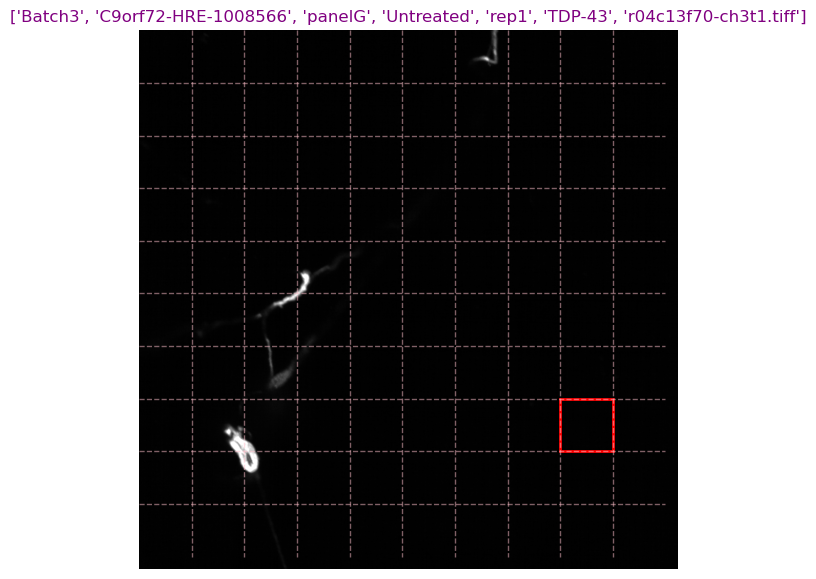

Cropping image to fit
Cropping will result in partial tiles being excluded.


SNR: 8.048328379233622
Entropy: 4.871609960619731


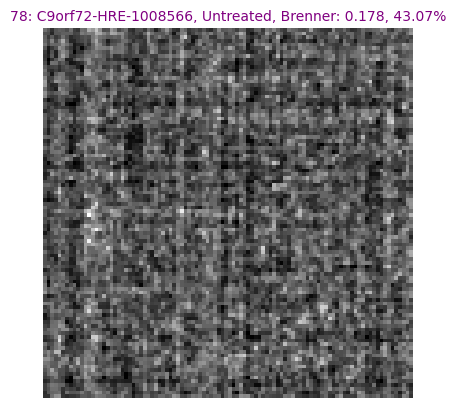

Cropping image to fit


--------------------------------
1
Brenner: 1203.516
Img shape: (1024, 1024)
58 /home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/TDP--43-G348V-1057052/panelG/Untreated/rep1/TDP-43/r02c13f25-ch3t1.tiff


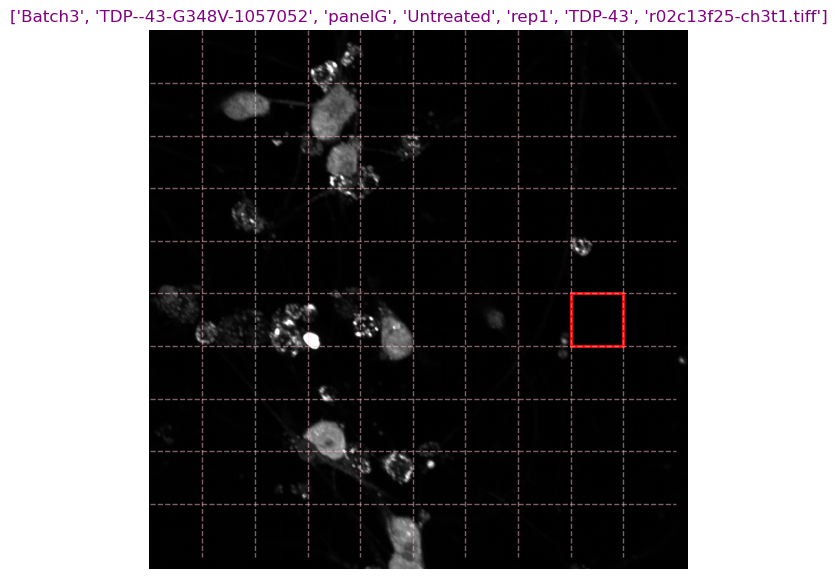

Cropping image to fit
Cropping will result in partial tiles being excluded.


SNR: 5.870948194295792
Entropy: 5.13428473792391


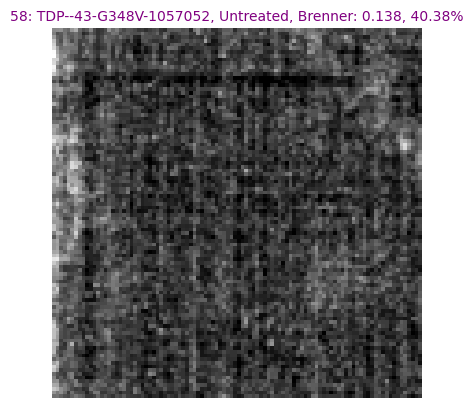

Cropping image to fit


--------------------------------
2
Brenner: 212.512
Img shape: (1024, 1024)
82 /home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/C9orf72-HRE-981344/panelG/Untreated/rep1/TDP-43/r08c13f08-ch3t1.tiff


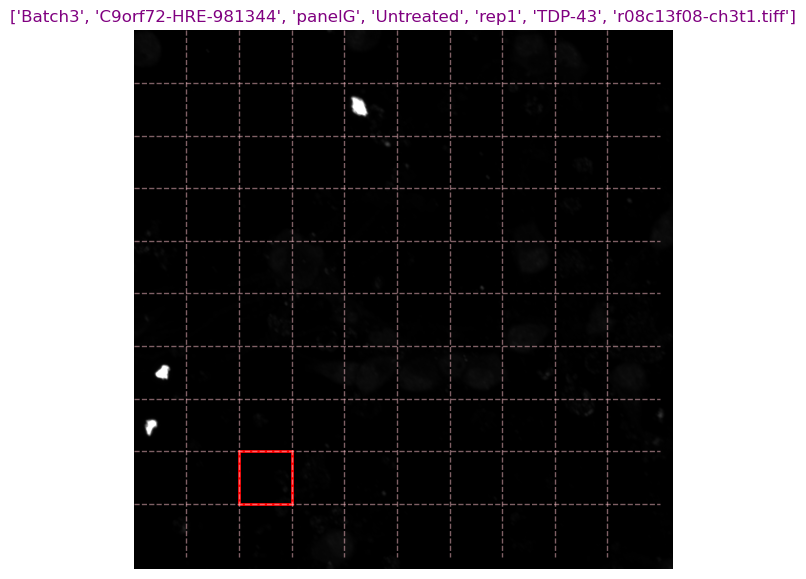

Cropping image to fit
Cropping will result in partial tiles being excluded.


SNR: -7.424574723747293
Entropy: 6.394015226367303


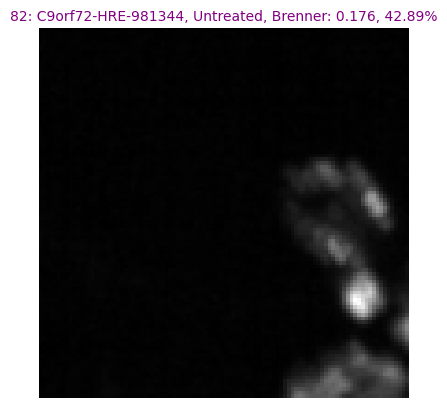

Cropping image to fit


--------------------------------
3
Brenner: 1203.516
Img shape: (1024, 1024)
44 /home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/TDP--43-G348V-1057052/panelG/Untreated/rep1/TDP-43/r02c13f25-ch3t1.tiff


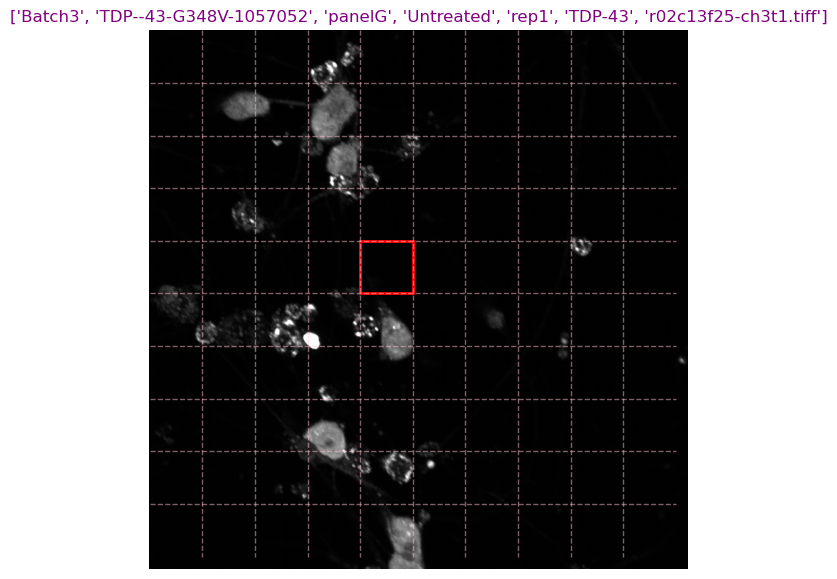

Cropping image to fit
Cropping will result in partial tiles being excluded.


SNR: -0.8835490301404096
Entropy: 5.517853683712202


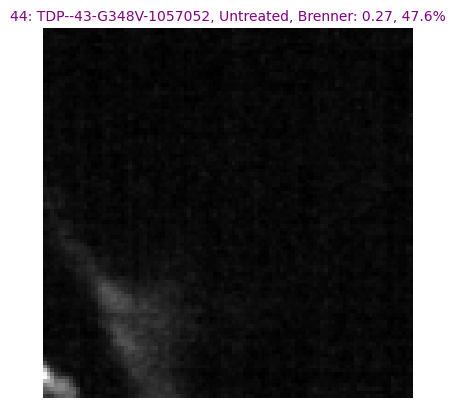

Cropping image to fit


--------------------------------
4
Brenner: 1423.107
Img shape: (1024, 1024)
63 /home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/TDP--43-G348V-1057052/panelG/Untreated/rep2/TDP-43/r02c14f22-ch3t1.tiff


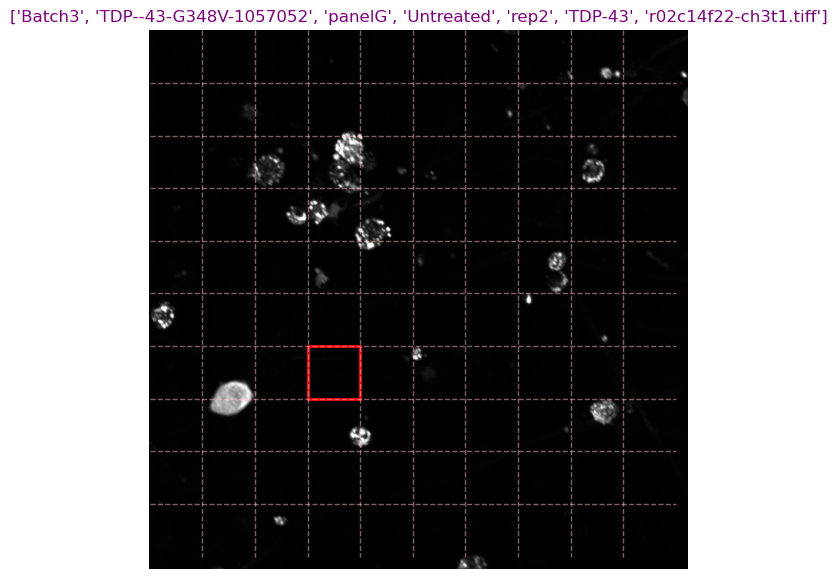

Cropping image to fit
Cropping will result in partial tiles being excluded.


SNR: 5.195098913892108
Entropy: 5.239369553102596


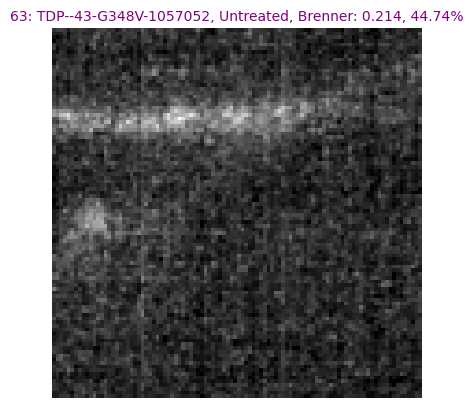

Cropping image to fit


--------------------------------
5
Brenner: 779.384
Img shape: (1024, 1024)
83 /home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/Control-1048087/panelG/Untreated/rep1/TDP-43/r01c13f34-ch3t1.tiff


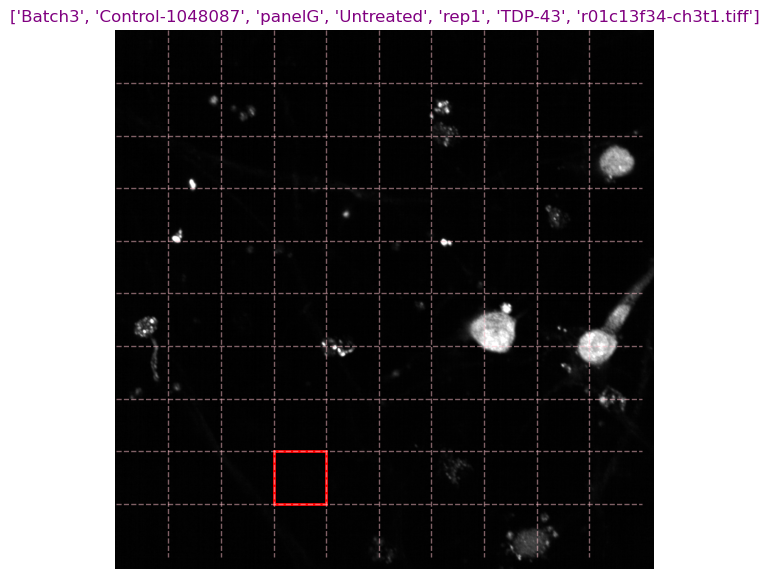

Cropping image to fit
Cropping will result in partial tiles being excluded.


SNR: 9.103776777636726
Entropy: 4.850690388912331


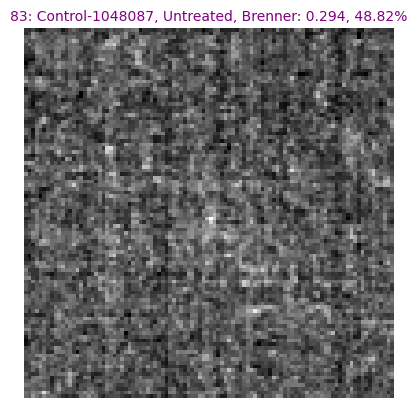

Cropping image to fit


--------------------------------
6
Brenner: 521.923
Img shape: (1024, 1024)
85 /home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/TDP--43-G348V-1057052/panelG/Untreated/rep2/TDP-43/r02c14f40-ch3t1.tiff


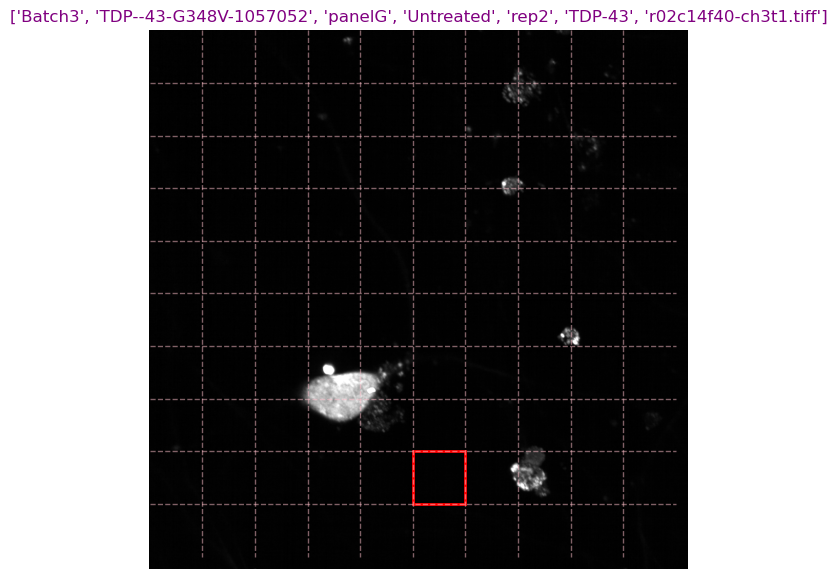

Cropping image to fit
Cropping will result in partial tiles being excluded.


SNR: 8.677817686950744
Entropy: 4.773708463386855


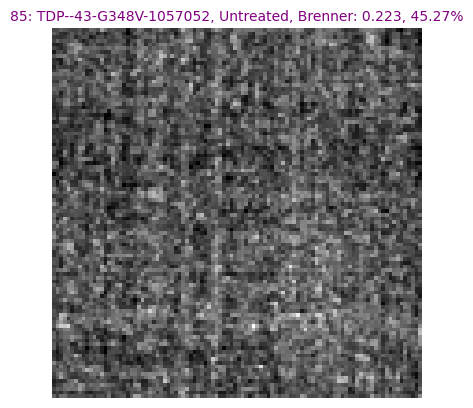

Cropping image to fit


--------------------------------
7
Brenner: 610.587
Img shape: (1024, 1024)
66 /home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/C9orf72-HRE-1008566/panelG/Untreated/rep1/TDP-43/r04c13f79-ch3t1.tiff


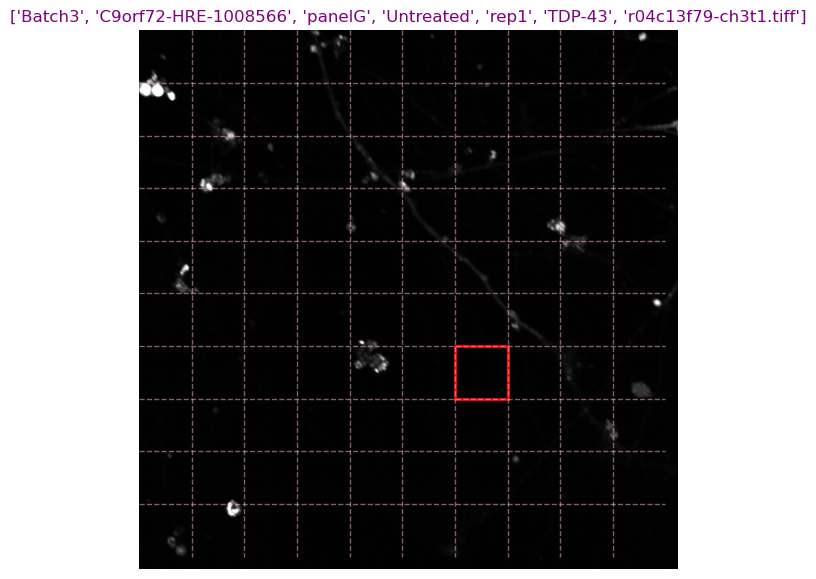

Cropping image to fit
Cropping will result in partial tiles being excluded.


SNR: 7.680558798390093
Entropy: 4.805745670709171


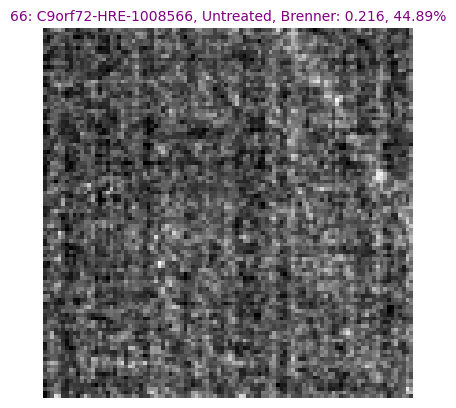

Cropping image to fit


--------------------------------
8
Brenner: 295.639
Img shape: (1024, 1024)
39 /home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/Control-1048087/panelG/Untreated/rep2/TDP-43/r01c14f15-ch3t1.tiff


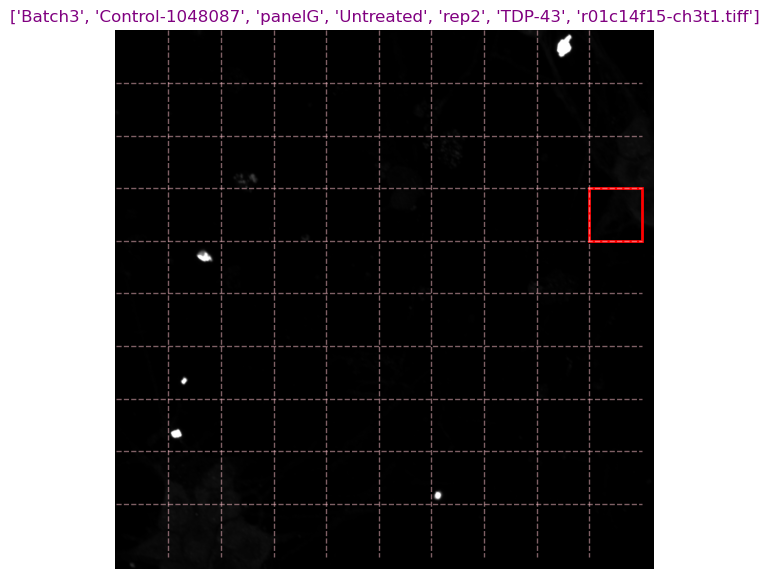

Cropping image to fit
Cropping will result in partial tiles being excluded.


SNR: -0.23527806327091666
Entropy: 9.617515697680169


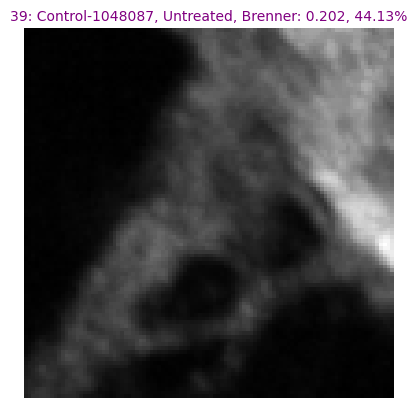

Cropping image to fit


--------------------------------
9
Brenner: 833.108
Img shape: (1024, 1024)
55 /home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/Control-1048087/panelG/Untreated/rep1/TDP-43/r01c13f94-ch3t1.tiff


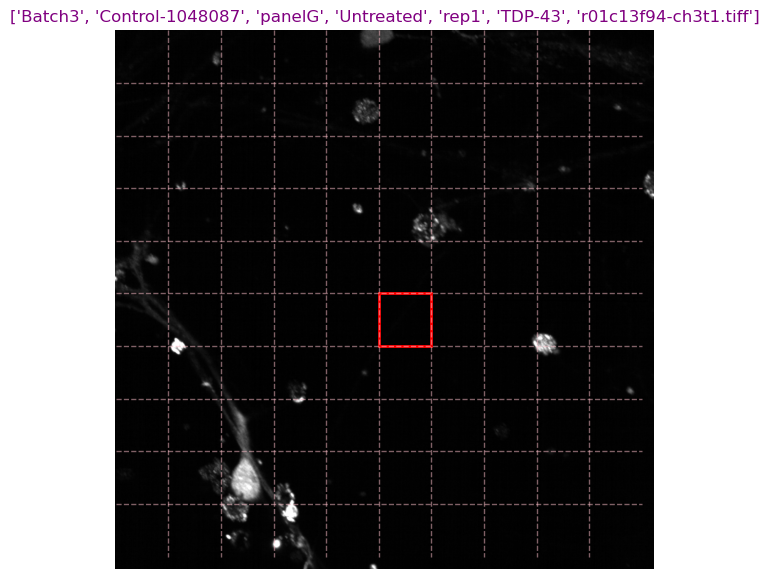

Cropping image to fit
Cropping will result in partial tiles being excluded.


SNR: 6.91818844667063
Entropy: 4.934084832051644


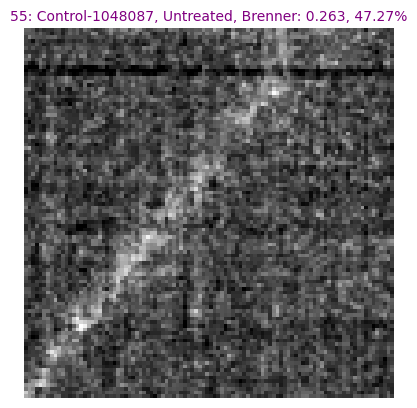

Cropping image to fit


--------------------------------
10
Brenner: 197.083
Img shape: (1024, 1024)
94 /home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/Control-1048087/panelG/Untreated/rep2/TDP-43/r01c14f20-ch3t1.tiff


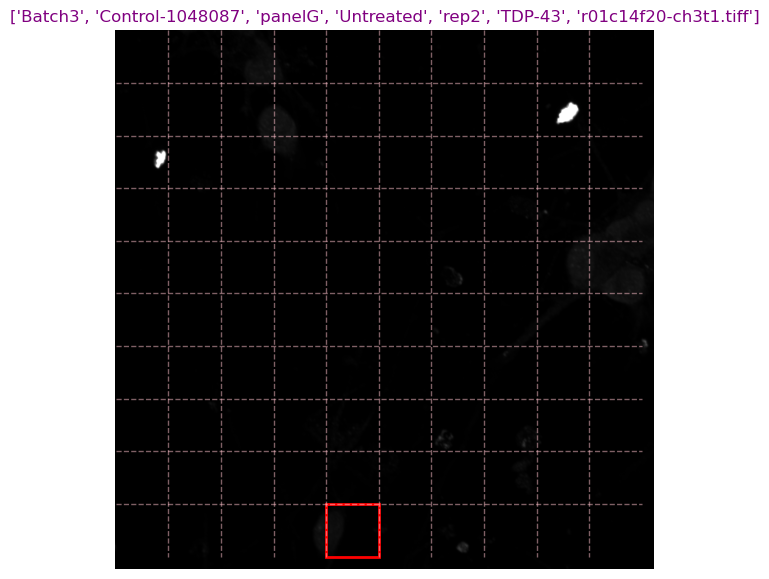

Cropping image to fit
Cropping will result in partial tiles being excluded.


SNR: -3.3168387698063704
Entropy: 8.316056106617413


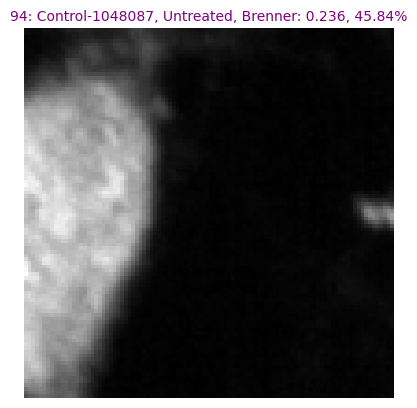

Cropping image to fit


--------------------------------
11
Brenner: 558.413
Img shape: (1024, 1024)
69 /home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/C9orf72-HRE-1008566/panelG/Untreated/rep1/TDP-43/r04c13f47-ch3t1.tiff


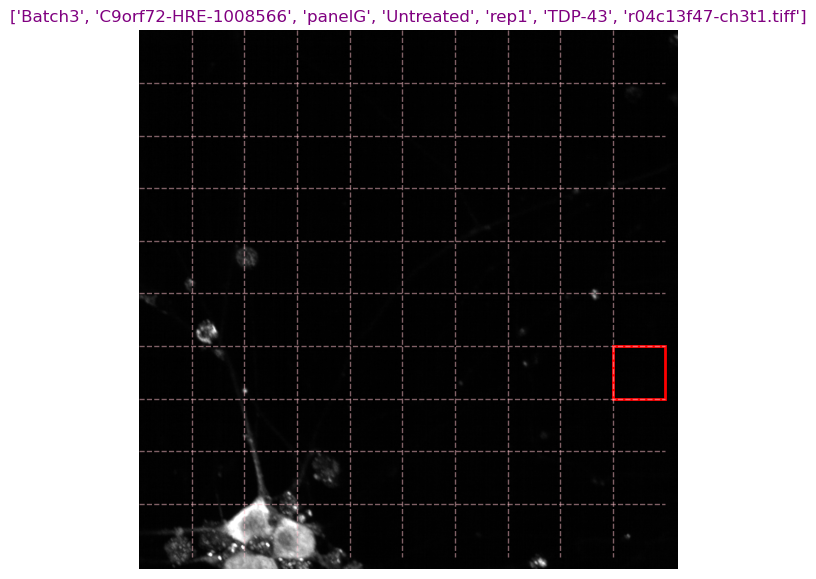

Cropping image to fit
Cropping will result in partial tiles being excluded.


SNR: 7.764743551478754
Entropy: 4.946857382507779


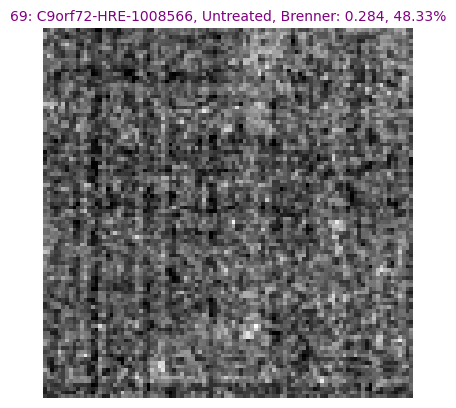

Cropping image to fit


--------------------------------
12
Brenner: 1533.225
Img shape: (1024, 1024)
3 /home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/TDP--43-G348V-1057052/panelG/Untreated/rep2/TDP-43/r02c14f23-ch3t1.tiff


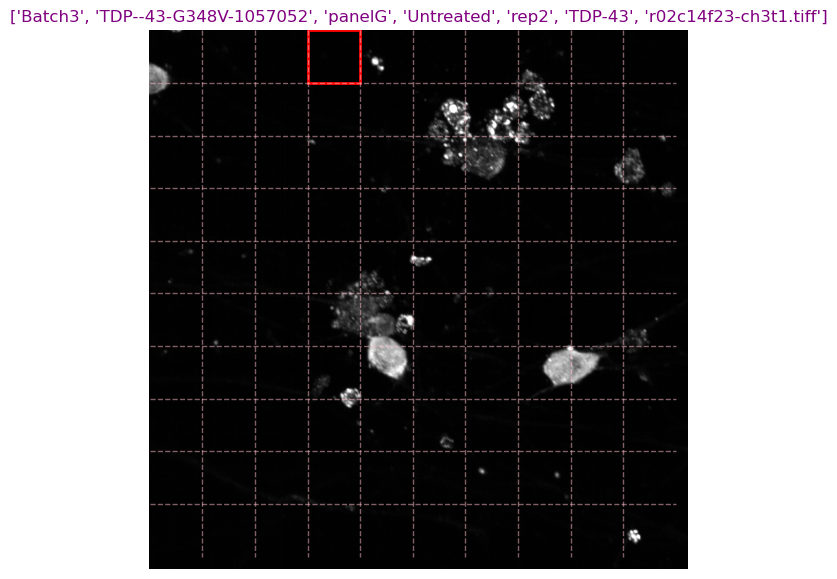

Cropping image to fit
Cropping will result in partial tiles being excluded.


SNR: 6.323290484079273
Entropy: 4.936509140333816


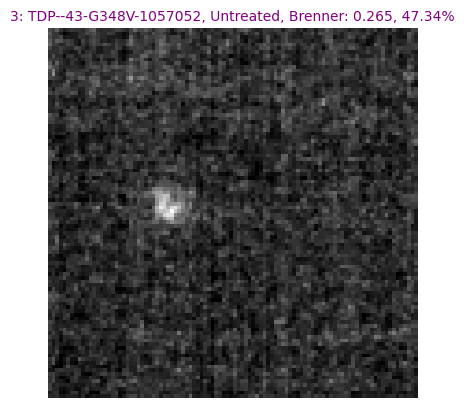

Cropping image to fit


--------------------------------
13
Brenner: 1184.052
Img shape: (1024, 1024)
58 /home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/TDP--43-G348V-1057052/panelG/Untreated/rep2/TDP-43/r02c14f08-ch3t1.tiff


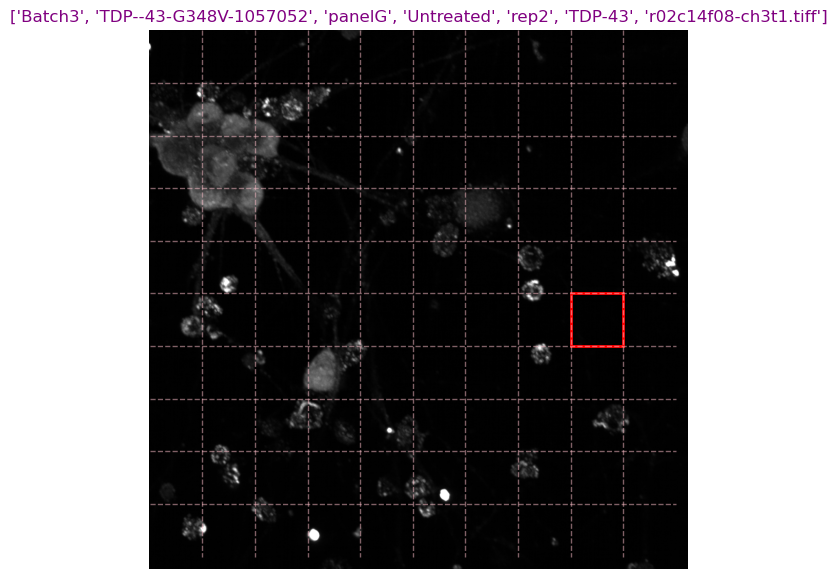

Cropping image to fit
Cropping will result in partial tiles being excluded.


SNR: 3.6908535531758013
Entropy: 5.1941803899467365


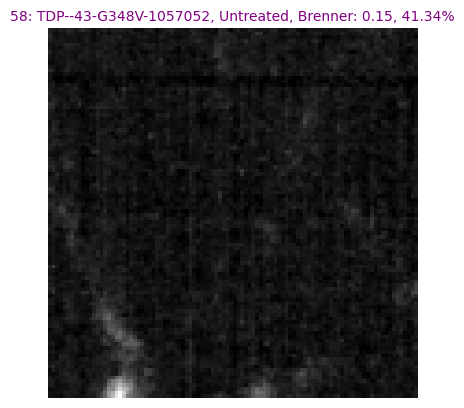

Cropping image to fit


--------------------------------
14
Brenner: 1269.49
Img shape: (1024, 1024)
32 /home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/C9orf72-HRE-1008566/panelG/Untreated/rep2/TDP-43/r04c14f22-ch3t1.tiff


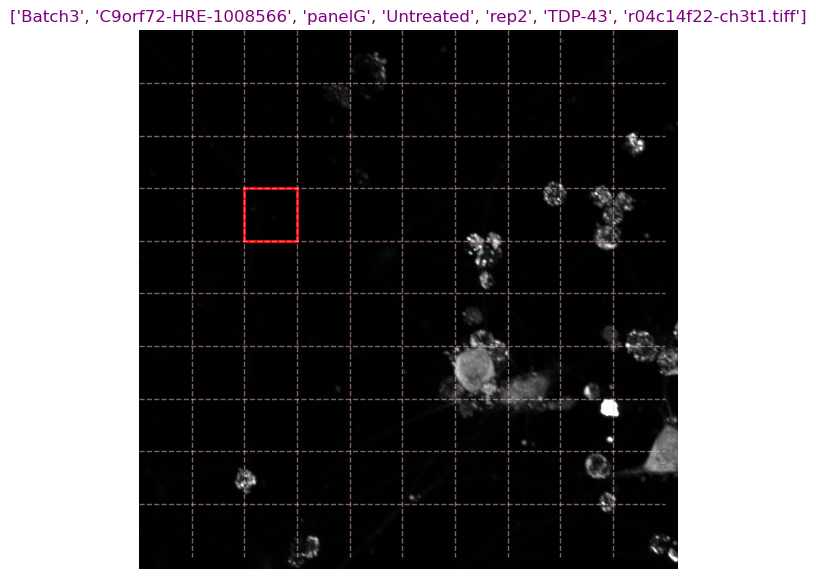

Cropping image to fit
Cropping will result in partial tiles being excluded.


SNR: 1.2847734119698573
Entropy: 5.385018722791356


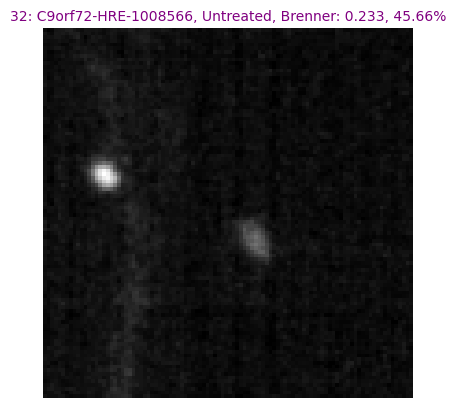

Cropping image to fit


--------------------------------
15
Brenner: 339.066
Img shape: (1024, 1024)
59 /home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/C9orf72-HRE-1008566/panelG/Untreated/rep1/TDP-43/r04c13f70-ch3t1.tiff


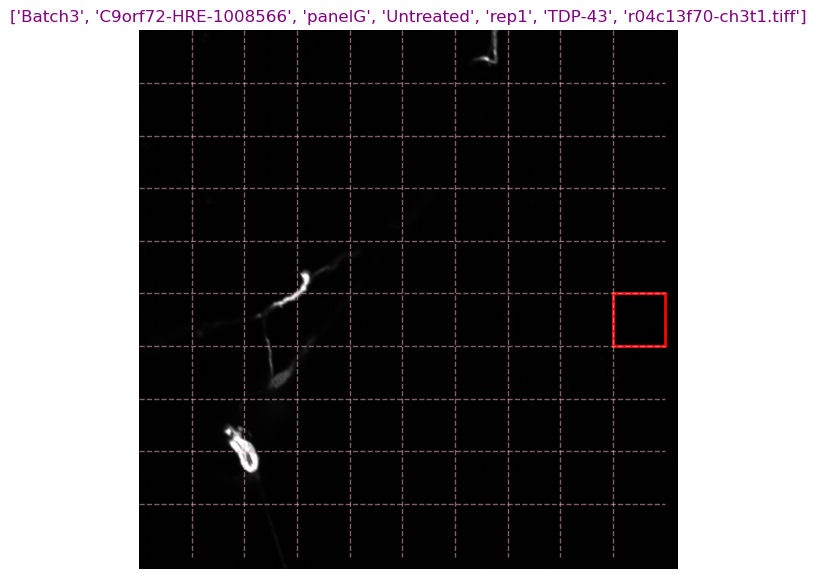

Cropping image to fit
Cropping will result in partial tiles being excluded.


SNR: 7.088380391315962
Entropy: 4.927645538670251


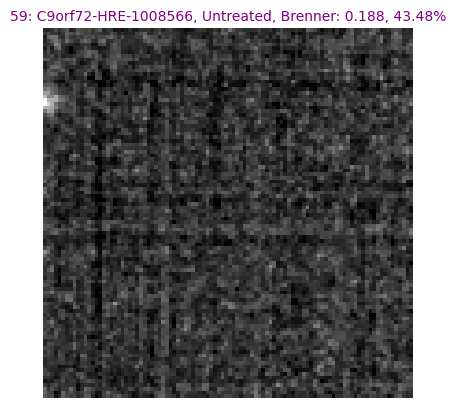

Cropping image to fit


--------------------------------
16
Brenner: 231.133
Img shape: (1024, 1024)
32 /home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/Control-1025045/panelG/Untreated/rep1/TDP-43/r03c13f50-ch3t1.tiff


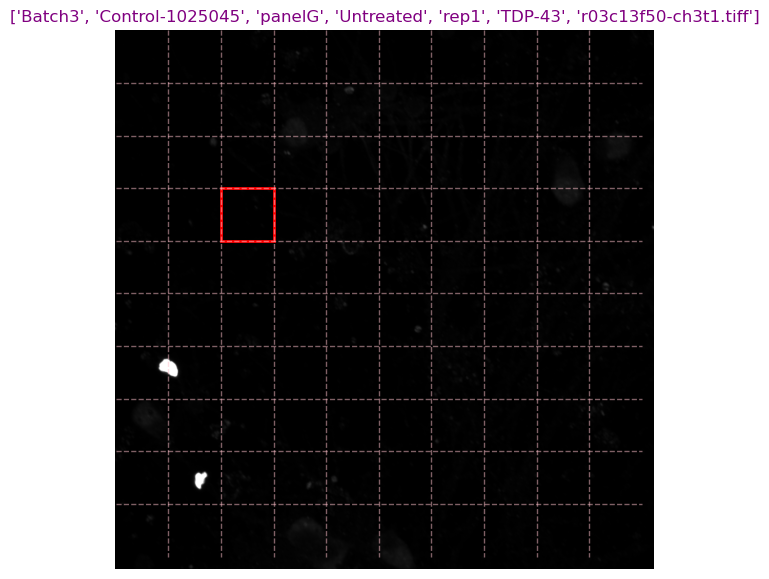

Cropping image to fit
Cropping will result in partial tiles being excluded.


SNR: -4.501876302238984
Entropy: 6.700931073786422


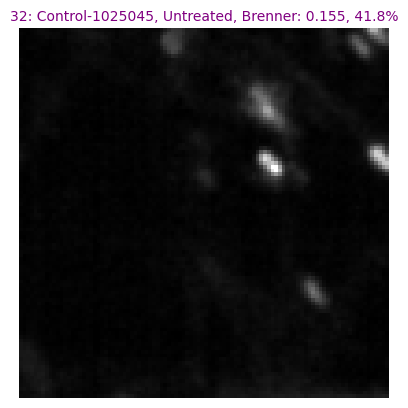

Cropping image to fit


--------------------------------
17
Brenner: 278.065
Img shape: (1024, 1024)
58 /home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/TDP--43-G348V-1057052/panelG/Untreated/rep2/TDP-43/r02c14f06-ch3t1.tiff


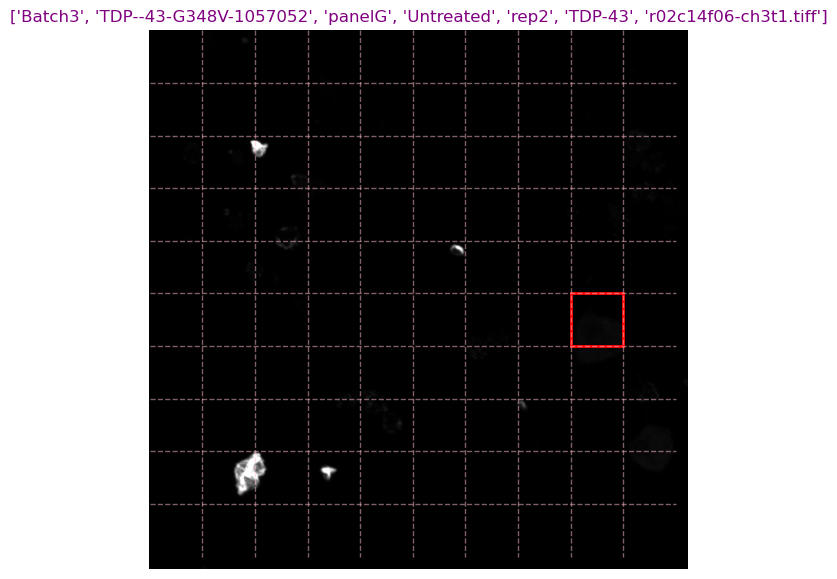

Cropping image to fit
Cropping will result in partial tiles being excluded.


SNR: 0.14677283568590802
Entropy: 9.418817078927757


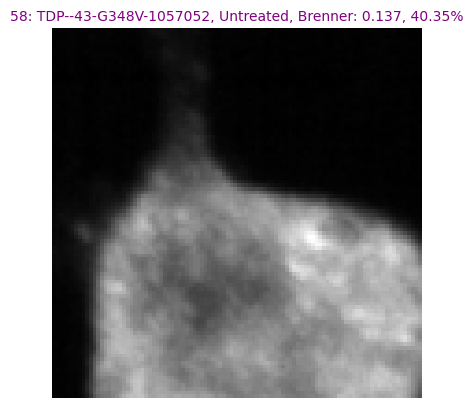

Cropping image to fit


--------------------------------
18
Brenner: 1105.327
Img shape: (1024, 1024)
66 /home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/TDP--43-N390D-1005373/panelG/Untreated/rep1/TDP-43/r06c13f70-ch3t1.tiff


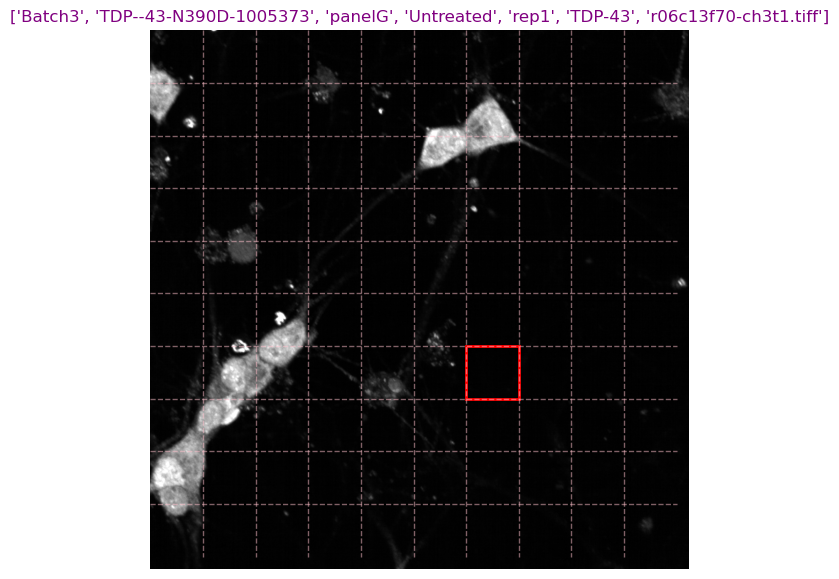

Cropping image to fit
Cropping will result in partial tiles being excluded.


SNR: 6.301620374443715
Entropy: 4.958411802841798


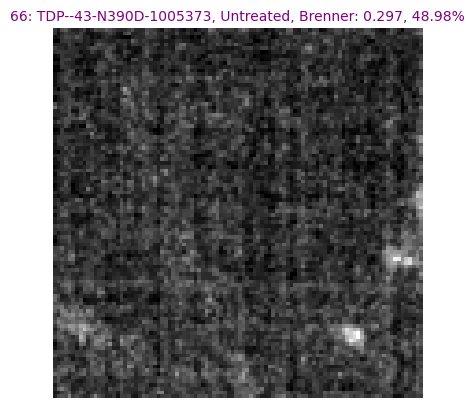

Cropping image to fit


--------------------------------
19
Brenner: 361.03
Img shape: (1024, 1024)
48 /home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/C9orf72-HRE-981344/panelG/Untreated/rep2/TDP-43/r08c14f80-ch3t1.tiff


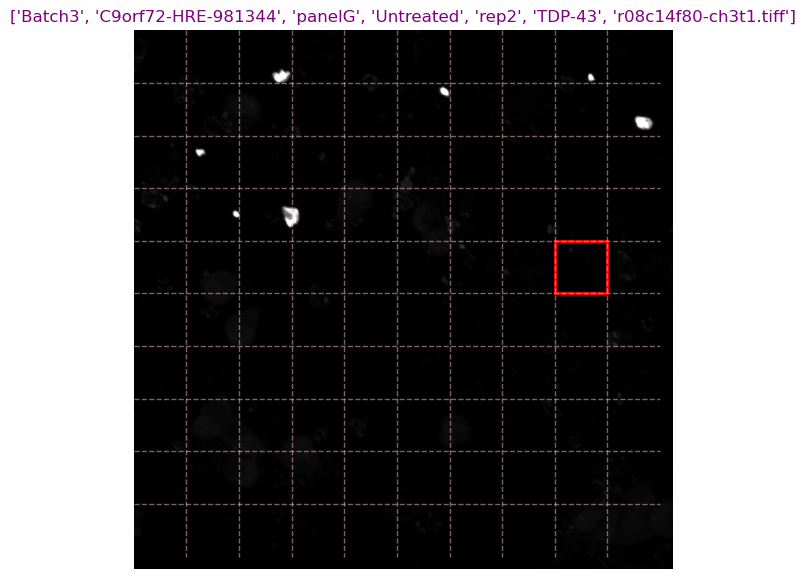

Cropping image to fit
Cropping will result in partial tiles being excluded.


SNR: -5.087630362974598
Entropy: 7.91853078785651


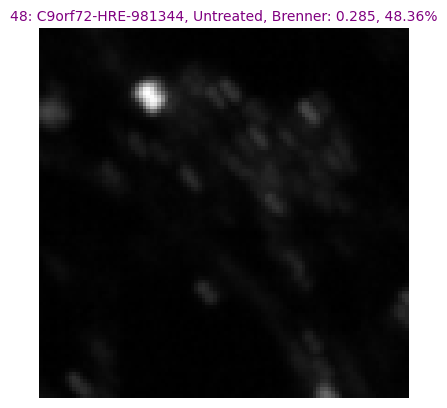

--------------------------------
20
Stopping at 20. There are 1600 images in total


In [183]:
#################### SAFE ZONE TO CHANGE ###############

marker = 'TDP-43' # MAKRENAME
# [marker] Options:
# 'Autophagy' 'DAPI' 'impaired_Autophagosome' 'UPR_ATF4' 'UPR_ATF6'
#  'UPR_IRE1a' 'Ubiquitin_levels' 'DNA_damage_P53BP1' 'Neuronal_activity'
#  'Necroptosis_HMGB1' 'Necrosis' 'DNA_damage_pH2Ax' 'Parthanatos_early'
#  'Cytoskeleton' 'Stress_initiation' 'mature_Autophagosome'
#  'Nuclear_speckles_SON' 'TDP-43' 'Nuclear_speckles_SC35'
#  'Splicing_factories' 'Aberrant_splicing' 'Parthanatos_late'
#  'Protein_degradation' 'Senescence_signaling' 'Apoptosis'
#  'Necroptosis_pMLKL'

per_min = 40
per_max = 50
max_samples = 20
#65-75
###################### END OF SAFE ZONE ###################



df_marker = df.loc[df['Marker'] == marker]
percentiles = df_marker[metric_name].describe(percentiles=percentiles_to_describe)

print(f'Showing images between %{per_min} - {per_max}')
threshold = percentiles[f'{per_min}%']
threshold_second = percentiles[f'{per_max}%']

c = (df_marker[metric_name]>=threshold) & (df_marker[metric_name]<=threshold_second) 

# threshold
df_marker_filtered = df_marker[c]
# shuffle
df_marker_filtered = df_marker_filtered.sample(frac=1, random_state=1)
# df_marker_filtered.index = range(len(df_marker_filtered))

print(f"Number of {marker} images in threshold {threshold} ({per_min}%) (and {threshold_second} ({per_max}%)): {len(df_marker_filtered)}")
print("\n")
print(df_marker_filtered['CellLine'].value_counts().to_string())
print("\n")
print(df_marker_filtered['Condition'].value_counts().to_string())
print("\n")
show_images(df_marker_filtered, max_samples=max_samples, show_tile = True)    

Cropping image to fit
Cropping will result in partial tiles being excluded.


/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/TDP--43-N390D-1005373/panelE/stress/rep1/DAPI/r14c09f85-ch1t1.tiff 95
(100, 100, 100, 1)
Tile 95 is at pixel location: (500, 900)


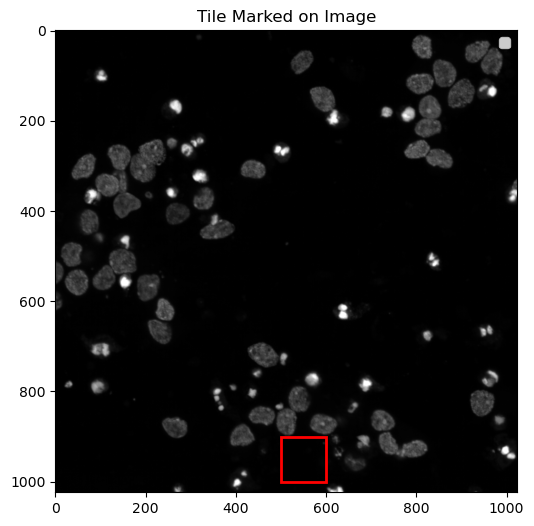

In [187]:
# path = df.Path.iloc[ind]; tile = df.Tile.iloc[ind]
path = '/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/TDP--43-N390D-1005373/panelE/stress/rep1/DAPI/r14c09f85-ch1t1.tiff'
tile_index = 95
print(path, tile_index)
target_path = os.path.join(imgs_path, path)
img = process_tif(target_path)
tiles = crop_image_to_tiles(img, [100, 100])
print(np.shape(tiles))
# show_processed_tif(target_path)
x,y = get_tile_location(tile_index, [img_shape, img_shape], tile_shape)
print(f"Tile {tile_index} is at pixel location: {x,y}")
# Plot the Image with the Marked Tile
plt.figure(figsize=(6, 6))
plt.imshow(img, cmap='gray')
x,y = get_tile_location(tile_index, [img_shape, img_shape], tile_shape)
plt.gca().add_patch(plt.Rectangle((x, y), tile_shape[0], tile_shape[1], edgecolor='red', linewidth=2, fill=False))
# plt.scatter(x + tile_shape[0] // 2, y + tile_shape[1] // 2,label=f"Tile {tile_index}")  # Mark center
plt.legend()
plt.title("Tile Marked on Image")
plt.show()

In [129]:
tile1 = img[y:y + tile_shape[0], x:x + tile_shape[1]]

In [134]:
get_metrics(tile1, True)

'Brenner: 3.53'

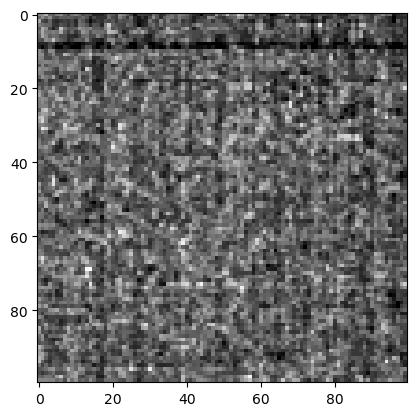

In [167]:
plt.imshow(tile1, cmap='gray')

In [173]:
from skimage.measure import shannon_entropy  

def compute_snr(image: np.ndarray) -> float:
    """
    Compute the Signal-to-Noise Ratio (SNR) of an image.
    
    Args:
        image (np.ndarray): Input grayscale or single-channel image.
    
    Returns:
        float: SNR value.
    """
    signal = np.mean(image)
    noise = np.std(image)
    return 20 * np.log10(signal / noise) if noise > 0 else float("inf")

def compute_entropy(image: np.ndarray) -> float:
    """
    Compute the entropy of an image.
    
    Args:
        image (np.ndarray): Input grayscale or single-channel image.
    
    Returns:
        float: Shannon entropy of the image.
    """
    return shannon_entropy(image)

In [175]:
print("SNR:", compute_snr(tile1))
print("Entropy:", compute_entropy(tile1))

SNR: 8.178361473846547
Entropy: 4.787818897424751


2. Setting Brenners in the csv

In [108]:
## Exp3
# thresholds = {
#     "Stress_initiation": (0, 99),
#     "Aberrant_splicing": (1, 97),
#     "Autophagy": (5, 97),
#     "DAPI": (0.2, 95),
#     "Apoptosis": (0.27, 95),
#     "impaired_Autophagosome": (5, 99),
#     "Cytoskeleton": (10, 99.8),
#     "DNA_damage_P53BP1": (0.3, 90),
#     "DNA_damage_pH2Ax": (7, 85),
#     "mature_Autophagosome": (2, 98),
#     "Necrosis": (4, 95),
#     "Neuronal_activity": (5, 90),
#     "Nuclear_speckles_SC35": (0.2, 85),
#     "Nuclear_speckles_SON": (0.2, 85),
#     "Parthanatos_early": (0, 85),
#     "Parthanatos_late": (5, 95),
#     "Protein_degradation": (5, 92),
#     "Senescence_signaling": (10, 90),
#     "Splicing_factories": (0, 95),
#     "TDP-43": (5, 99.2),
#     "Ubiquitin_levels": (2, 90),
#     "UPR_ATF4": (2, 99.7), 
#     "UPR_ATF6": (3, 100),
#     "UPR_IRE1a": (2, 98),
#     "Necroptosis_pMLKL": (5, 90),
#     "Necroptosis_HMGB1": (0.01, 90),
# }
## Exp 4 
thresholds = {
    "Stress_initiation": (0.3, 98),
    "Aberrant_splicing": (2, 97),
    "Autophagy": (0, 98),
    "DAPI": (0.2, 98.3),
    "Apoptosis": (0.5, 95),
    "impaired_Autophagosome": (10, 99.5),
    "Cytoskeleton": (10, 99.9),
    "DNA_damage_P53BP1": (0.3, 92),
    "DNA_damage_pH2Ax": (7, 95),
    "mature_Autophagosome": (5, 98.85),
    "Necrosis": (7.2, 98),
    "Neuronal_activity": (5, 96),
    "Nuclear_speckles_SC35": (0.1, 92),
    "Nuclear_speckles_SON": (0.2, 85),
    "Parthanatos_early": (0, 99),
    "Parthanatos_late": (5, 99),
    "Protein_degradation": (2, 98),
    "Senescence_signaling": (4, 99.75),
    "Splicing_factories": (0, 95),
    "TDP-43": (10, 99.8),
    "Ubiquitin_levels": (0.2, 90),
    "UPR_ATF4": (5, 99.75),
    "UPR_ATF6": (3, 100),
    "UPR_IRE1a": (2, 98),
    "Necroptosis_pMLKL": (2, 95),
    "Necroptosis_HMGB1": (0.2, 90),
}

mappings = update_all_mappings(mappings, thresholds, df)
mappings.to_csv(mappings_filepath)
mappings

Lower_bound Upper_bound
Autophagy                    77.11     3643.55
DAPI                        162.43     1984.34
impaired_Autophagosome       466.9     7129.52
UPR_ATF4                    230.42     3558.27
UPR_ATF6                    213.64      9053.7
UPR_IRE1a                   263.48    11484.03
Ubiquitin_levels            210.67     9956.22
DNA_damage_P53BP1           150.02     2652.31
Neuronal_activity           546.47    13455.45
Necroptosis_HMGB1           123.12     2471.23
Necrosis                     254.5    10482.71
DNA_damage_pH2Ax            410.64     6598.32
Parthanatos_early            137.2     5700.18
Cytoskeleton                888.14    10840.65
Stress_initiation           220.82    16393.83
mature_Autophagosome         438.1     8414.47
Nuclear_speckles_SON        179.19     4282.81
TDP-43                      218.89     3811.66
Nuclear_speckles_SC35       257.07     2255.27
Splicing_factories           98.85     6509.52
Aberrant_splicing           191.74    18579.07
Parthanatos_late            374.91     7383.43
Protein_degradation         606.13     6506.79
Senescence_signaling        791.78     9301.37
Apoptosis                   327.34     7732.09
Necroptosis_pMLKL           464.63     7275.48

-----------------------------------------------------